In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings     # for supressing a warning when importing large files
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from collections import Counter
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,roc_auc_score,classification_report
import pickle
from scipy import stats
import time
from sklearn.model_selection import GridSearchCV,KFold

from pylab import rcParams

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
# Load Train Dataset

Train=pd.read_csv("G:/Provider Fraud/Train-1542865627584.csv")
Train_Beneficiarydata=pd.read_csv("G:/Provider Fraud/Train_Beneficiarydata-1542865627584.csv")
Train_Inpatientdata=pd.read_csv("G:/Provider Fraud/Train_Inpatientdata-1542865627584.csv")
Train_Outpatientdata=pd.read_csv("G:/Provider Fraud/Train_Outpatientdata-1542865627584.csv")

# Load Test Dataset

Test=pd.read_csv("G:/Provider Fraud/Test-1542969243754.csv")
Test_Beneficiarydata=pd.read_csv("G:/Provider Fraud/Test_Beneficiarydata-1542969243754.csv")
Test_Inpatientdata=pd.read_csv("G:/Provider Fraud/Test_Inpatientdata-1542969243754.csv")
Test_Outpatientdata=pd.read_csv("G:/Provider Fraud/Test_Outpatientdata-1542969243754.csv")

In [5]:
## Lets Check Shape of datasets 

print('Shape of Train data :',Train.shape)
print('Shape of Train_Beneficiarydata data :',Train_Beneficiarydata.shape)
print('Shape of Train_Inpatientdata data :',Train_Inpatientdata.shape)
print('Shape of Train_Outpatientdata data :',Train_Outpatientdata.shape)

print('Shape of Test data :',Test.shape)
print('Shape of Test_Beneficiarydata data :',Test_Beneficiarydata.shape)
print('Shape of Test_Inpatientdata data :',Test_Inpatientdata.shape)
print('Shape of Test_Outpatientdata data :',Test_Outpatientdata.shape)

Shape of Train data : (5410, 2)
Shape of Train_Beneficiarydata data : (138556, 25)
Shape of Train_Inpatientdata data : (40474, 30)
Shape of Train_Outpatientdata data : (517737, 27)
Shape of Test data : (1353, 1)
Shape of Test_Beneficiarydata data : (63968, 25)
Shape of Test_Inpatientdata data : (9551, 30)
Shape of Test_Outpatientdata data : (125841, 27)


In [6]:
print('\033[1m'"Train Dataset"+ "\033[0m","\n",Train.head(4),'\n')

print('\033[1m'+"Test Dataset"+ "\033[0m")

print(Test.head(4)) # We don't have Target Variable Fraud in the test dataset and this target variable we need to predict

Train Dataset 
    Provider PotentialFraud
0  PRV51001             No
1  PRV51003            Yes
2  PRV51004             No
3  PRV51005            Yes 

Test Dataset
   Provider
0  PRV51002
1  PRV51006
2  PRV51009
3  PRV51010


In [7]:
#To Check the summary of the train dataset

Train.describe()

,Provider,PotentialFraud
count,5410,5410
unique,5410,2
top,PRV55256,No
freq,1,4904


In [8]:
## Lets check whether  providers details are unique or not in train data
print(Train.Provider.value_counts(sort=True,ascending=False).head(5))  # number of unique providers in train data.Check for duplicates

print('\n Total missing values in Train :',Train.isna().sum().sum())

print('\n Total missing values in Train :',Test.isna().sum().sum())

PRV55256    1
PRV54502    1
PRV54451    1
PRV56580    1
PRV55937    1
Name: Provider, dtype: int64

 Total missing values in Train : 0

 Total missing values in Train : 0


In [9]:
print('\033[1m'+"Train Dataset"+ "\033[0m")

display(Train_Beneficiarydata.head(5))

print('\033[1m'+"Test Dataset"+ "\033[0m")

display(Test_Beneficiarydata.head(5))

Train Dataset


,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200


Test Dataset


,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11007,1940-09-01,2009-12-01,1,2,0,45,610,12,12,...,2,1,2,1,1,2,0,0,1490,160
2,BENE11010,1936-07-01,NaN,2,1,0,41,30,12,12,...,2,1,1,1,2,2,0,0,1170,660
3,BENE11011,1914-03-01,NaN,2,2,0,1,360,12,12,...,1,1,2,2,1,1,5000,1068,250,320
4,BENE11014,1938-04-01,NaN,2,1,Y,45,780,12,12,...,1,2,1,2,2,2,21260,2136,120,100


In [10]:
#Lets Check missing values in each column in beneficiary data :


print('\033[1m'+"Train Beneficiary Dataset"+ "\033[0m")

print(Train_Beneficiarydata.isna().sum())

print('\033[1m'+"Test Beneficiary Dataset"+ "\033[0m")

print(Train_Beneficiarydata.isna().sum())

Train Beneficiary Dataset
BeneID                                  0
DOB                                     0
DOD                                137135
Gender                                  0
Race                                    0
RenalDiseaseIndicator                   0
State                                   0
County                                  0
NoOfMonths_PartACov                     0
NoOfMonths_PartBCov                     0
ChronicCond_Alzheimer                   0
ChronicCond_Heartfailure                0
ChronicCond_KidneyDisease               0
ChronicCond_Cancer                      0
ChronicCond_ObstrPulmonary              0
ChronicCond_Depression                  0
ChronicCond_Diabetes                    0
ChronicCond_IschemicHeart               0
ChronicCond_Osteoporasis                0
ChronicCond_rheumatoidarthritis         0
ChronicCond_stroke                      0
IPAnnualReimbursementAmt                0
IPAnnualDeductibleAmt                   0
OPAnnual

In [11]:
# Lets check data types of each column in beneficiary data

Train_Beneficiarydata.dtypes

BeneID                             object
DOB                                object
DOD                                object
Gender                              int64
Race                                int64
RenalDiseaseIndicator              object
State                               int64
County                              int64
NoOfMonths_PartACov                 int64
NoOfMonths_PartBCov                 int64
ChronicCond_Alzheimer               int64
ChronicCond_Heartfailure            int64
ChronicCond_KidneyDisease           int64
ChronicCond_Cancer                  int64
ChronicCond_ObstrPulmonary          int64
ChronicCond_Depression              int64
ChronicCond_Diabetes                int64
ChronicCond_IschemicHeart           int64
ChronicCond_Osteoporasis            int64
ChronicCond_rheumatoidarthritis     int64
ChronicCond_stroke                  int64
IPAnnualReimbursementAmt            int64
IPAnnualDeductibleAmt               int64
OPAnnualReimbursementAmt          

In [12]:
Train_Beneficiarydata.describe(include='all')

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
count,138556,138556,1421,138556.000000,138556.000000,138556,138556.000000,138556.000000,138556.000000,138556.000000,...,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000
unique,138556,900,11,NaN,NaN,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,BENE107266,1939-10-01,2009-12-01,NaN,NaN,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,540,182,NaN,NaN,118978,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1.570932,1.254511,NaN,25.666734,374.424745,11.907727,11.910145,...,1.644476,1.398142,1.324143,1.725317,1.743180,1.920942,3660.346502,399.847296,1298.219348,377.718258
std,NaN,NaN,NaN,0.494945,0.717007,NaN,15.223443,266.277581,1.032332,0.936893,...,0.478674,0.489517,0.468056,0.446356,0.436881,0.269831,9568.621827,956.175202,2493.901134,645.530187
min,NaN,NaN,NaN,1.000000,1.000000,NaN,1.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-8000.000000,0.000000,-70.000000,0.000000
25%,NaN,NaN,NaN,1.000000,1.000000,NaN,11.000000,141.000000,12.000000,12.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,170.000000,40.000000
50%,NaN,NaN,NaN,2.000000,1.000000,NaN,25.000000,340.000000,12.000000,12.000000,...,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,570.000000,170.000000
75%,NaN,NaN,NaN,2.000000,1.000000,NaN,39.000000,570.000000,12.000000,12.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2280.000000,1068.000000,1500.000000,460.000000


In [13]:
##Replacing 2 with 0 for chronic conditions ,that means chronic condition No is 0 and yes is 1

Train_Beneficiarydata = Train_Beneficiarydata.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

Train_Beneficiarydata = Train_Beneficiarydata.replace({'RenalDiseaseIndicator': 'Y'}, 1)


## Same thing do in the Test Dataset also 
Test_Beneficiarydata = Test_Beneficiarydata.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

Test_Beneficiarydata = Test_Beneficiarydata.replace({'RenalDiseaseIndicator': 'Y'}, 1)

In [14]:
## Lets Create Age column to the Train and Test dataset

Train_Beneficiarydata['DOB'] = pd.to_datetime(Train_Beneficiarydata['DOB'] )
Train_Beneficiarydata['DOD'] = pd.to_datetime(Train_Beneficiarydata['DOD'],errors='ignore')
Train_Beneficiarydata['Age'] = round(((Train_Beneficiarydata['DOD'] - Train_Beneficiarydata['DOB']).dt.days)/365)


Test_Beneficiarydata['DOB'] = pd.to_datetime(Test_Beneficiarydata['DOB'])
Test_Beneficiarydata['DOD'] = pd.to_datetime(Test_Beneficiarydata['DOD'],errors='ignore')
Test_Beneficiarydata['Age'] = round(((Test_Beneficiarydata['DOD'] - Test_Beneficiarydata['DOB']).dt.days)/365)

In [15]:
Train_Beneficiarydata.head(10)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,...,1,1,0,1,1,36000,3204,60,70,NaN
1,BENE11002,1936-09-01,NaT,2,1,0,39,280,12,12,...,0,0,0,0,0,0,0,30,50,NaN
2,BENE11003,1936-08-01,NaT,1,1,0,52,590,12,12,...,0,1,0,0,0,0,0,90,40,NaN
3,BENE11004,1922-07-01,NaT,1,1,0,39,270,12,12,...,1,1,1,1,0,0,0,1810,760,NaN
4,BENE11005,1935-09-01,NaT,1,1,0,24,680,12,12,...,1,0,0,0,0,0,0,1790,1200,NaN
5,BENE11006,1976-09-01,NaT,2,1,0,23,810,12,12,...,0,0,0,0,0,0,0,500,0,NaN
6,BENE11007,1940-09-01,2009-12-01,1,2,0,45,610,12,12,...,1,0,1,1,0,0,0,1490,160,69.0
7,BENE11008,1934-02-01,NaT,2,1,0,15,140,12,12,...,1,0,0,0,0,0,0,30,0,NaN
8,BENE11009,1929-06-01,NaT,1,1,1,44,230,12,12,...,1,0,0,0,0,0,0,100,0,NaN
9,BENE11010,1936-07-01,NaT,2,1,0,41,30,12,12,...,1,1,1,0,0,0,0,1170,660,NaN


In [16]:
## As we can see above Age column have some Nan values, This is due to DOD is Nan for that record.
## As we see that last DOD value is 2017-12-01 ,which means Beneficiary Details data is of year 2017.
## so we will calculate age of other benficiaries for year 2017.

Train_Beneficiarydata.Age.fillna(round(((pd.to_datetime('2017-12-01' ) - Train_Beneficiarydata['DOB']).dt.days)/365),
                                 inplace=True)


Test_Beneficiarydata.Age.fillna(round(((pd.to_datetime('2017-12-01') - Test_Beneficiarydata['DOB']).dt.days)/365),
                                 inplace=True)

In [17]:
Train_Beneficiarydata.head(5)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,...,1,1,0,1,1,36000,3204,60,70,75.0
1,BENE11002,1936-09-01,NaT,2,1,0,39,280,12,12,...,0,0,0,0,0,0,0,30,50,81.0
2,BENE11003,1936-08-01,NaT,1,1,0,52,590,12,12,...,0,1,0,0,0,0,0,90,40,81.0
3,BENE11004,1922-07-01,NaT,1,1,0,39,270,12,12,...,1,1,1,1,0,0,0,1810,760,95.0
4,BENE11005,1935-09-01,NaT,1,1,0,24,680,12,12,...,1,0,0,0,0,0,0,1790,1200,82.0


In [18]:
#Lets create a new variable 'WhetherDead' with flag 1 means Dead and 0 means not Dead

Train_Beneficiarydata.loc[Train_Beneficiarydata.DOD.isna(),'WhetherDead']=0
Train_Beneficiarydata.loc[Train_Beneficiarydata.DOD.notna(),'WhetherDead']=1



Test_Beneficiarydata.loc[Test_Beneficiarydata.DOD.isna(),'WhetherDead']=0
Test_Beneficiarydata.loc[Test_Beneficiarydata.DOD.notna(),'WhetherDead']=1

In [19]:
print('\033[1m'+"Train Dataset"+ "\033[0m")

print(Train_Beneficiarydata.loc[:,'WhetherDead'].head(7))

print('\033[1m'+"Test Dataset"+ "\033[0m")

print(Train_Beneficiarydata.loc[:,'WhetherDead'].head(7))

Train Dataset
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    1.0
Name: WhetherDead, dtype: float64
Test Dataset
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    1.0
Name: WhetherDead, dtype: float64


In [20]:
# Summary of Inpatient Dataset

print('\033[1m'+"Train Inpatient Dataset"+ "\033[0m")

display(Train_Inpatientdata.head(5))

print('\033[1m'+"Test Inpatient Dataset"+ "\033[0m")

display(Train_Inpatientdata.head(5))

Train Inpatient Dataset


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


Test Inpatient Dataset


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [21]:
#Lets check missing values in each column in inpatient data

print('\033[1m'+"Train Inpatient Dataset"+ "\033[0m")

print(Train_Inpatientdata.isna().sum())

print('\033[1m'+"Test Inpatient Dataset"+ "\033[0m")

print(Test_Inpatientdata.isna().sum())

Train Inpatient Dataset
BeneID                        0
ClaimID                       0
ClaimStartDt                  0
ClaimEndDt                    0
Provider                      0
InscClaimAmtReimbursed        0
AttendingPhysician          112
OperatingPhysician        16644
OtherPhysician            35784
AdmissionDt                   0
ClmAdmitDiagnosisCode         0
DeductibleAmtPaid           899
DischargeDt                   0
DiagnosisGroupCode            0
ClmDiagnosisCode_1            0
ClmDiagnosisCode_2          226
ClmDiagnosisCode_3          676
ClmDiagnosisCode_4         1534
ClmDiagnosisCode_5         2894
ClmDiagnosisCode_6         4838
ClmDiagnosisCode_7         7258
ClmDiagnosisCode_8         9942
ClmDiagnosisCode_9        13497
ClmDiagnosisCode_10       36547
ClmProcedureCode_1        17326
ClmProcedureCode_2        35020
ClmProcedureCode_3        39509
ClmProcedureCode_4        40358
ClmProcedureCode_5        40465
ClmProcedureCode_6        40474
dtype: int64
Tes

In [22]:
## As patient can be admitted for only for 1 day,we will add 1 to the difference of Discharge Date and Admission Date 

Train_Inpatientdata['AdmissionDt'] = pd.to_datetime(Train_Inpatientdata['AdmissionDt'])
Train_Inpatientdata['DischargeDt'] = pd.to_datetime(Train_Inpatientdata['DischargeDt'])
Train_Inpatientdata['AdmitForDays'] = ((Train_Inpatientdata['DischargeDt'] - Train_Inpatientdata['AdmissionDt']).dt.days.abs())+1


Test_Inpatientdata['AdmissionDt'] = pd.to_datetime(Test_Inpatientdata['AdmissionDt'])
Test_Inpatientdata['DischargeDt'] = pd.to_datetime(Test_Inpatientdata['DischargeDt'])
Test_Inpatientdata['AdmitForDays'] = ((Test_Inpatientdata['DischargeDt'] - Test_Inpatientdata['AdmissionDt']).dt.days.abs())+1

In [23]:
Train_Inpatientdata.loc[:,['AdmissionDt','DischargeDt','AdmitForDays']]

,AdmissionDt,DischargeDt,AdmitForDays
0,2009-04-12,2009-04-18,7
1,2009-08-31,2009-09-02,3
2,2009-09-17,2009-09-20,4
3,2009-02-14,2009-02-22,9
4,2009-08-13,2009-08-30,18
...,...,...,...
40469,2009-09-28,2009-10-02,5
40470,2009-11-03,2009-11-06,4
40471,2009-11-18,2009-11-22,5
40472,2009-12-17,2009-12-18,2


In [24]:
## Lets check Min and Max values of AdmitforDays column in Train and Test.
print('Min AdmitForDays Train:- ',Train_Inpatientdata.AdmitForDays.min())
print('Max AdmitForDays Train:- ',Train_Inpatientdata.AdmitForDays.max())
print(Train_Inpatientdata.AdmitForDays.isnull().sum() )  #Check Null values.

print('Min AdmitForDays Test:- ',Test_Inpatientdata.AdmitForDays.min())
print('Max AdmitForDays Test:- ',Test_Inpatientdata.AdmitForDays.max())
print(Test_Inpatientdata.AdmitForDays.isnull().sum())   #Check Null values.

Min AdmitForDays Train:-  1
Max AdmitForDays Train:-  36
0
Min AdmitForDays Test:-  1
Max AdmitForDays Test:-  36
0


In [25]:
# Summary of Outpatient Dataset

print('\033[1m'+"Train Outpatient Dataset"+ "\033[0m")

display(Train_Outpatientdata.head(5))

print('\033[1m'+"Test Outpatient Dataset"+ "\033[0m")

display(Train_Outpatientdata.head(5))

Train Outpatient Dataset


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


Test Outpatient Dataset


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [26]:
# Lets check the null values in each column of Outpatient Dataset

print('\033[1m'+"Train Outpatient Dataset"+ "\033[0m")

print(Train_Outpatientdata.isna().sum())

print('\033[1m'+"Test Outpatient Dataset"+ "\033[0m")

print(Test_Outpatientdata.isna().sum())

Train Outpatient Dataset
BeneID                         0
ClaimID                        0
ClaimStartDt                   0
ClaimEndDt                     0
Provider                       0
InscClaimAmtReimbursed         0
AttendingPhysician          1396
OperatingPhysician        427120
OtherPhysician            322691
ClmDiagnosisCode_1         10453
ClmDiagnosisCode_2        195380
ClmDiagnosisCode_3        314480
ClmDiagnosisCode_4        392141
ClmDiagnosisCode_5        443393
ClmDiagnosisCode_6        468981
ClmDiagnosisCode_7        484776
ClmDiagnosisCode_8        494825
ClmDiagnosisCode_9        502899
ClmDiagnosisCode_10       516654
ClmProcedureCode_1        517575
ClmProcedureCode_2        517701
ClmProcedureCode_3        517733
ClmProcedureCode_4        517735
ClmProcedureCode_5        517737
ClmProcedureCode_6        517737
DeductibleAmtPaid              0
ClmAdmitDiagnosisCode     412312
dtype: int64
Test Outpatient Dataset
BeneID                         0
ClaimID       

In [27]:
## Lets Check Shape of datasets after adding new variables

print('Shape of Train data :',Train.shape)
print('Shape of Train_Beneficiarydata data :',Train_Beneficiarydata.shape)
print('Shape of Train_Inpatientdata data :',Train_Inpatientdata.shape)
print('Shape of Train_Outpatientdata data :',Train_Outpatientdata.shape)

print('Shape of Test data :',Test.shape)
print('Shape of Test_Beneficiarydata data :',Test_Beneficiarydata.shape)
print('Shape of Test_Inpatientdata data :',Test_Inpatientdata.shape)

Shape of Train data : (5410, 2)
Shape of Train_Beneficiarydata data : (138556, 27)
Shape of Train_Inpatientdata data : (40474, 31)
Shape of Train_Outpatientdata data : (517737, 27)
Shape of Test data : (1353, 1)
Shape of Test_Beneficiarydata data : (63968, 27)
Shape of Test_Inpatientdata data : (9551, 31)


### Merge Beneficiary, Inpatient and Outpatient Dataset into a single dataset

In [28]:
Train_patient_merge_id = [i for i in Train_Outpatientdata.columns if i in Train_Inpatientdata.columns]

# Merge Inpatient, Outpatient and beneficiary dataframe into a single patient dataset
Train_Patient_data = pd.merge(Train_Inpatientdata, Train_Outpatientdata,
                    left_on = Train_patient_merge_id,
                    right_on = Train_patient_merge_id,
                    how = 'outer').\
          merge(Train_Beneficiarydata,left_on='BeneID',right_on='BeneID',how='inner')

In [29]:
Test_patient_merge_id = [i for i in Test_Outpatientdata.columns if i in Test_Inpatientdata.columns]

# Merge Inpatient, Outpatient and beneficiary dataframe into a single patient dataset
Test_Patient_data = pd.merge(Test_Inpatientdata, Test_Outpatientdata,
                    left_on = Test_patient_merge_id,
                    right_on = Test_patient_merge_id,
                    how = 'outer').\
          merge(Test_Beneficiarydata,left_on='BeneID',right_on='BeneID',how='inner')

In [30]:
# Shape of Merging Dataset 

print("Train Dataset Shape after merge:",Train_Patient_data.shape)

print("Test Dataset Shape after merge:",Test_Patient_data.shape)

Train Dataset Shape after merge: (558211, 57)
Test Dataset Shape after merge: (135392, 57)


### Exploratory Data Analysis on Train_Patient_data dataset

In [31]:
Train_Patient_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 57 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   BeneID                           558211 non-null  object        
 1   ClaimID                          558211 non-null  object        
 2   ClaimStartDt                     558211 non-null  object        
 3   ClaimEndDt                       558211 non-null  object        
 4   Provider                         558211 non-null  object        
 5   InscClaimAmtReimbursed           558211 non-null  int64         
 6   AttendingPhysician               556703 non-null  object        
 7   OperatingPhysician               114447 non-null  object        
 8   OtherPhysician                   199736 non-null  object        
 9   AdmissionDt                      40474 non-null   datetime64[ns]
 10  ClmAdmitDiagnosisCode            145899 non-

In [32]:
# To check the number of missing values in the Train_Pateint_data

Train_Patient_data.isnull().sum()

BeneID                                  0
ClaimID                                 0
ClaimStartDt                            0
ClaimEndDt                              0
Provider                                0
InscClaimAmtReimbursed                  0
AttendingPhysician                   1508
OperatingPhysician                 443764
OtherPhysician                     358475
AdmissionDt                        517737
ClmAdmitDiagnosisCode              412312
DeductibleAmtPaid                     899
DischargeDt                        517737
DiagnosisGroupCode                 517737
ClmDiagnosisCode_1                  10453
ClmDiagnosisCode_2                 195606
ClmDiagnosisCode_3                 315156
ClmDiagnosisCode_4                 393675
ClmDiagnosisCode_5                 446287
ClmDiagnosisCode_6                 473819
ClmDiagnosisCode_7                 492034
ClmDiagnosisCode_8                 504767
ClmDiagnosisCode_9                 516396
ClmDiagnosisCode_10               

In [33]:
### There are missing values in AttendingPhysician, OperatingPhysician and OtherPhysician columns, so we need to handle these varaibles 

Train_Patient_data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']]

,AttendingPhysician,OperatingPhysician,OtherPhysician
0,PHY390922,NaN,NaN
1,PHY318495,PHY318495,NaN
2,PHY372395,NaN,PHY324689
3,PHY369659,PHY392961,PHY349768
4,PHY379398,NaN,NaN
...,...,...,...
558206,PHY364188,PHY364188,PHY385752
558207,PHY423019,PHY332284,NaN
558208,PHY361063,NaN,NaN
558209,PHY403198,NaN,PHY419379


In [34]:
Train_Patient_data[['AttendingPhysician','OperatingPhysician', 'OtherPhysician']].describe()

,AttendingPhysician,OperatingPhysician,OtherPhysician
count,556703,114447,199736
unique,82063,35315,46457
top,PHY330576,PHY330576,PHY412132
freq,2534,424,1247


In [35]:
## We are replacing these columns value with 0 and 1 where we have value we are replacing it with 1 and in place of null value we replace it with 0.


Train_Patient_data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(Train_Patient_data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']].isnull(), 0, 1)

In [36]:
Train_Patient_data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']]

,AttendingPhysician,OperatingPhysician,OtherPhysician
0,1,0,0
1,1,1,0
2,1,0,1
3,1,1,1
4,1,0,0
...,...,...,...
558206,1,1,1
558207,1,1,0
558208,1,0,0
558209,1,0,1


In [38]:
### Add a new variable in which it tells us how many total types of physicians used for the particular claim or patient.


Train_Patient_data['N_Types_Physicians'] = Train_Patient_data['AttendingPhysician'] +  Train_Patient_data['OperatingPhysician'] + Train_Patient_data['OtherPhysician']

Train_Patient_data['N_Types_Physicians']

0         1
1         2
2         2
3         3
4         1
         ..
558206    3
558207    2
558208    1
558209    2
558210    2
Name: N_Types_Physicians, Length: 558211, dtype: int64

In [39]:
Train_Patient_data.isnull().sum() #We can see here new variable "N_Type_Physicians" is added

BeneID                                  0
ClaimID                                 0
ClaimStartDt                            0
ClaimEndDt                              0
Provider                                0
InscClaimAmtReimbursed                  0
AttendingPhysician                      0
OperatingPhysician                      0
OtherPhysician                          0
AdmissionDt                        517737
ClmAdmitDiagnosisCode              412312
DeductibleAmtPaid                     899
DischargeDt                        517737
DiagnosisGroupCode                 517737
ClmDiagnosisCode_1                  10453
ClmDiagnosisCode_2                 195606
ClmDiagnosisCode_3                 315156
ClmDiagnosisCode_4                 393675
ClmDiagnosisCode_5                 446287
ClmDiagnosisCode_6                 473819
ClmDiagnosisCode_7                 492034
ClmDiagnosisCode_8                 504767
ClmDiagnosisCode_9                 516396
ClmDiagnosisCode_10               

In [40]:
### Handling Missing values on"DiagnosisGroupCode"

Train_Patient_data['DiagnosisGroupCode'].describe()

count     40474
unique      736
top         882
freq        179
Name: DiagnosisGroupCode, dtype: object

In [41]:
#Here we are finding out each DignosisGroupCode Count

Count_DiagnosisGroupCode=Train_Patient_data['DiagnosisGroupCode'].value_counts()
Count_DiagnosisGroupCode=Count_DiagnosisGroupCode[:20] # To show only top 20 codes 
Count_DiagnosisGroupCode

882    179
884    174
166    168
183    165
939    163
883    160
168    160
887    159
204    158
945    156
876    156
949    154
167    153
208    153
202    153
198    152
188    151
177    150
196    150
192    150
Name: DiagnosisGroupCode, dtype: int64

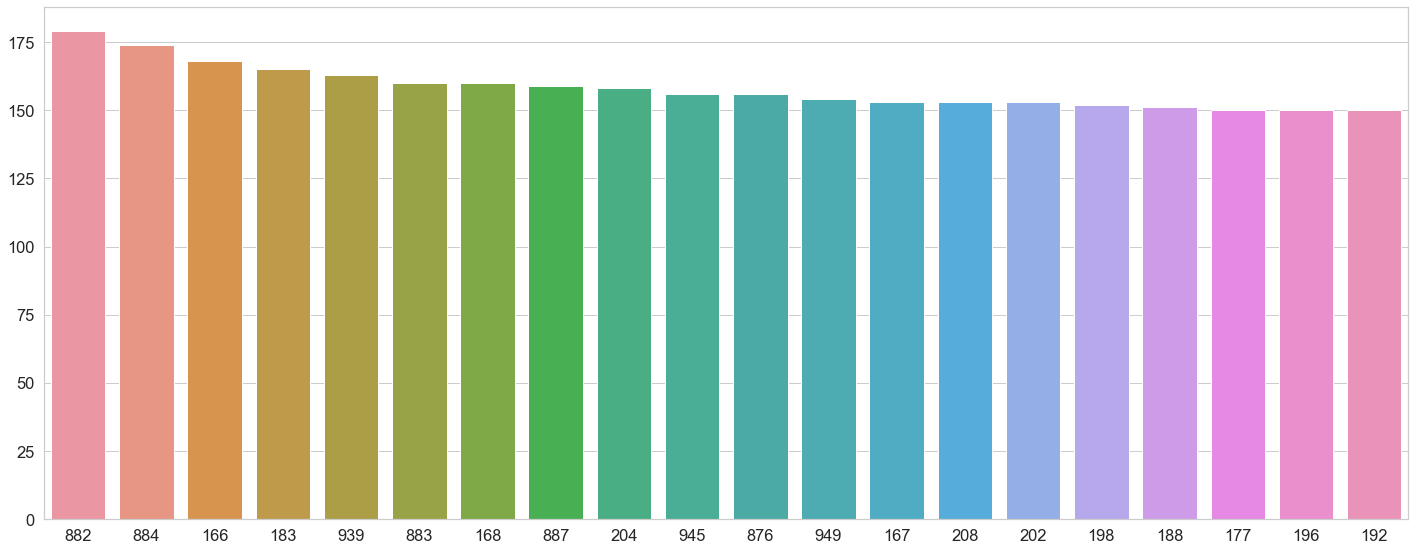

In [42]:
### Visualization of top 20 DignosisGroupCode

fig=plt.figure(figsize=(20,8))
sns.barplot(Count_DiagnosisGroupCode.index,Count_DiagnosisGroupCode.values)
fig.tight_layout()

## From here we can see that DignosisGroupCode 882 has maximum count that is 179 

In [43]:
## Since in this columns we have maximum values as null, so we are handling this by creating a new column
## so we are creating a new variable/column "IsDiagnosisCode" in which value will either "1" or "0" 
## if in a claim there is a groupDiagnosiscode  has null value then in "IsDiagnosisCode" column value is 0 otherwise 1

Train_Patient_data['IsDiagnosisCode'] = np.where(Train_Patient_data.DiagnosisGroupCode.notnull(), 1, 0)
Train_Patient_data = Train_Patient_data.drop(['DiagnosisGroupCode'], axis = 1) # We are droping the column "DiagnosisGroupCode"

In [44]:
Train_Patient_data['IsDiagnosisCode']

0         1
1         1
2         1
3         1
4         0
         ..
558206    0
558207    0
558208    0
558209    0
558210    0
Name: IsDiagnosisCode, Length: 558211, dtype: int32

In [45]:
### Handling missing values for "DeductibleamtPaid" column

Train_Patient_data['DeductibleAmtPaid'].isnull().sum()  #Check number of missing values in this variable

899

In [46]:
#Describing this column by omiting the Nan, to check mean , variance , skewness etc

sc.stats.describe(Train_Patient_data['DeductibleAmtPaid'],nan_policy='omit')

DescribeResult(nobs=557312, minmax=(masked_array(data=0.,
             mask=False,
       fill_value=1e+20), masked_array(data=1068.,
             mask=False,
       fill_value=1e+20)), mean=78.42108549609554, variance=75085.21352232435, skewness=masked_array(data=3.32405005,
             mask=False,
       fill_value=1e+20), kurtosis=9.085581103391615)

<AxesSubplot:xlabel='DeductibleAmtPaid', ylabel='count'>

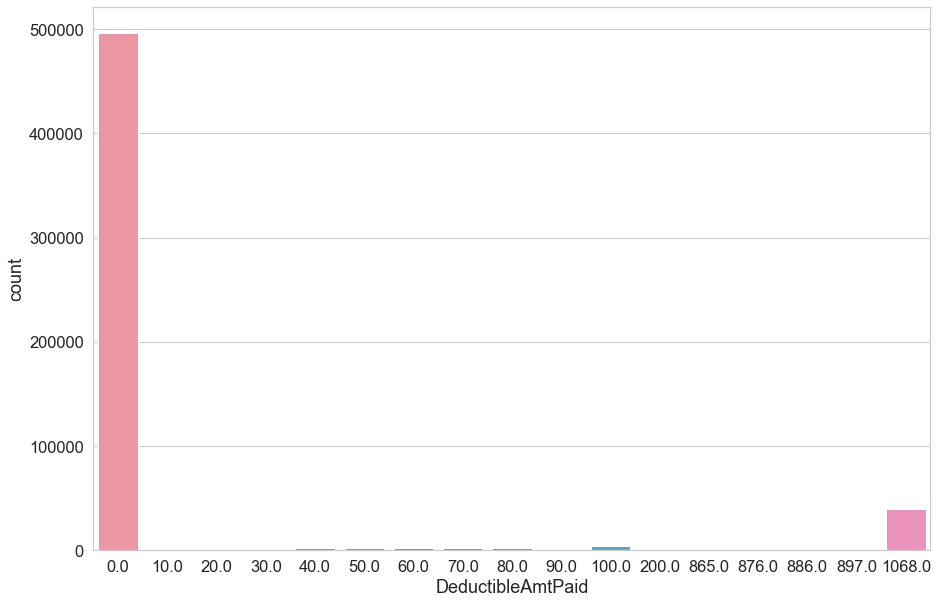

In [47]:
## Count Plot of "DeductibleAmtPaid" maximum values are 0 in this 

fig=plt.figure(figsize=(15,10))
sns.countplot(Train_Patient_data['DeductibleAmtPaid'])

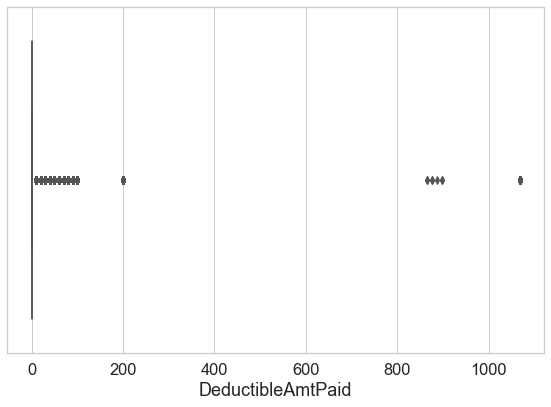

In [48]:
## Box plot of this "DeductibleAmtPaid", maximum values are 0 that shows here.

fig=plt.figure(figsize=(8,6))
sns.boxplot(Train_Patient_data['DeductibleAmtPaid'])
fig.tight_layout()

In [49]:
## So from the above analysis we can reach to the conclusion that we replace missing values with 0 

Train_Patient_data['DeductibleAmtPaid'].fillna(0,inplace=True)

In [50]:
### We are also creating one new variable "IsDeductibleAmtPaid" which tells us that particular claim has any DeductibleAmtPaid or not

Train_Patient_data['IsDeductibleAmtPaid']=np.where(Train_Patient_data['DeductibleAmtPaid']==0,0,1) 

0    497600
1     60611
Name: IsDeductibleAmtPaid, dtype: int64


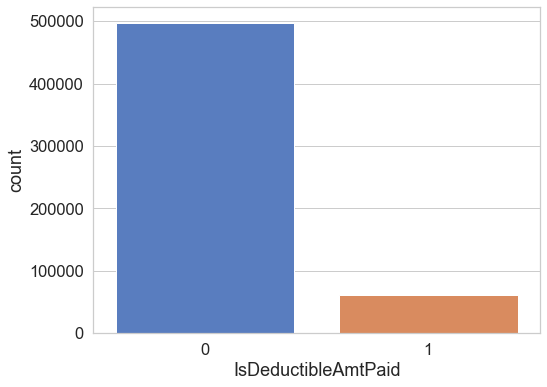

In [51]:
#So from this plot we can say that maximum claims doesn't have any "DeductibleAmtPaid"

fig=plt.figure(figsize=(8,6))
sns.countplot(Train_Patient_data['IsDeductibleAmtPaid'])

print(Train_Patient_data['IsDeductibleAmtPaid'].value_counts())

In [52]:
### Handling missing values for "AdmitForDays" column

Train_Patient_data['AdmitForDays'].isnull().sum() # Count of missing values in this column

517737

In [53]:
# Replace all value with 0 as these all are the patients that didn't admit in the hospital

Train_Patient_data['AdmitForDays'].fillna(0,inplace=True)

In [54]:
Train_Patient_data['AdmitForDays'].isnull().sum()

0

In [55]:
#In this dataset now we have some Date columns in which missing values are there, which we do not need to handle and we can drop those columns also. 

Train_Patient_data.isnull().sum() 


# Now we need to handle missing values of ClmDiagnosisCodes and ClmProcedureCode columns 

BeneID                                  0
ClaimID                                 0
ClaimStartDt                            0
ClaimEndDt                              0
Provider                                0
InscClaimAmtReimbursed                  0
AttendingPhysician                      0
OperatingPhysician                      0
OtherPhysician                          0
AdmissionDt                        517737
ClmAdmitDiagnosisCode              412312
DeductibleAmtPaid                       0
DischargeDt                        517737
ClmDiagnosisCode_1                  10453
ClmDiagnosisCode_2                 195606
ClmDiagnosisCode_3                 315156
ClmDiagnosisCode_4                 393675
ClmDiagnosisCode_5                 446287
ClmDiagnosisCode_6                 473819
ClmDiagnosisCode_7                 492034
ClmDiagnosisCode_8                 504767
ClmDiagnosisCode_9                 516396
ClmDiagnosisCode_10                553201
ClmProcedureCode_1                

In [56]:
## First we handle ClmProcedureCodes variables 

ClmProcedure_vars = ['ClmProcedureCode_{}'.format(x) for x in range(1,7)]
ClmProcedure_vars

['ClmProcedureCode_1',
 'ClmProcedureCode_2',
 'ClmProcedureCode_3',
 'ClmProcedureCode_4',
 'ClmProcedureCode_5',
 'ClmProcedureCode_6']

In [57]:
Train_Patient_data[ClmProcedure_vars]

,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,NaN,NaN,NaN,NaN,NaN,NaN
1,7092.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,331.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
558206,NaN,NaN,NaN,NaN,NaN,NaN
558207,NaN,NaN,NaN,NaN,NaN,NaN
558208,NaN,NaN,NaN,NaN,NaN,NaN
558209,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
## To Check how many null values are in each Clmprocedurecodes
## By this we find out that in code_6 column all are Nan values 

Train_Patient_data[ClmProcedure_vars].isnull().sum()

ClmProcedureCode_1    534901
ClmProcedureCode_2    552721
ClmProcedureCode_3    557242
ClmProcedureCode_4    558093
ClmProcedureCode_5    558202
ClmProcedureCode_6    558211
dtype: int64

In [59]:
Train_Patient_data[ClmProcedure_vars].describe()

,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
count,23310.000000,5490.000000,969.000000,118.000000,9.000000,0.0
mean,5896.154612,4106.358106,4221.123839,4070.262712,5269.444444,NaN
std,3050.489933,2031.640878,2281.849885,2037.626990,2780.071632,NaN
min,11.000000,42.000000,42.000000,42.000000,2724.000000,NaN
25%,3848.000000,2724.000000,2724.000000,2754.250000,4139.000000,NaN
50%,5363.000000,4019.000000,4019.000000,4019.000000,4139.000000,NaN
75%,8669.000000,4439.000000,5185.000000,4439.000000,5185.000000,NaN
max,9999.000000,9999.000000,9999.000000,9986.000000,9982.000000,NaN


In [60]:
# This function helps us find the length of unique values in each row/record
def N_unique_values(df):
    return np.array([len(set([i for i in x[~pd.isnull(x)]])) for x in df.values])

In [61]:
# We count the number of procedureCode for each claim and store these value in a new variable
Train_Patient_data['N_Procedure'] = N_unique_values(Train_Patient_data[ClmProcedure_vars])

## So from here we get to know that 534901 claims/records has 0 claim procedure codes, 17820 claims/records has 1 claimprocedurecodes and so on

Train_Patient_data['N_Procedure'].value_counts()

0    534901
1     17820
2      4521
3       851
4       109
5         9
Name: N_Procedure, dtype: int64

In [62]:
### Handling of 'ClmDiagnosisCode'

# We count the number of claims
ClmDiagnosisCode_vars =['ClmAdmitDiagnosisCode'] + ['ClmDiagnosisCode_{}'.format(x) for x in range(1, 11)]


ClmDiagnosisCode_vars

['ClmAdmitDiagnosisCode',
 'ClmDiagnosisCode_1',
 'ClmDiagnosisCode_2',
 'ClmDiagnosisCode_3',
 'ClmDiagnosisCode_4',
 'ClmDiagnosisCode_5',
 'ClmDiagnosisCode_6',
 'ClmDiagnosisCode_7',
 'ClmDiagnosisCode_8',
 'ClmDiagnosisCode_9',
 'ClmDiagnosisCode_10']

In [63]:
# We count the number of CLMDiagnosisCode for each claim and store these value in a new variable

Train_Patient_data['N_UniqueDiagnosis_Claims'] = N_unique_values(Train_Patient_data[ClmDiagnosisCode_vars])


Train_Patient_data['N_UniqueDiagnosis_Claims'].value_counts()

1     152275
2     132264
3      86573
4      57288
5      30338
10     22219
9      20821
6      19652
7      13770
8      11576
0       8319
11      3116
Name: N_UniqueDiagnosis_Claims, dtype: int64

### EDA on other remaining variables

In [64]:
Train_Patient_data.Gender.describe()

count    558211.000000
mean          1.578838
std           0.493746
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: Gender, dtype: float64

In [65]:
Train_Patient_data.Gender.value_counts() # here we have only 1 and 2, so we can change it to binary as 0 or 1 

2    323114
1    235097
Name: Gender, dtype: int64

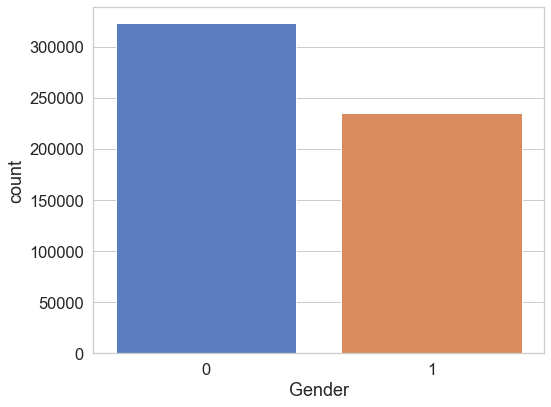

In [66]:
Train_Patient_data['Gender']=Train_Patient_data['Gender'].replace(2,0) # replacing 2 with 0 



## Countplot of Gender Column, Here we can consider 0 as Female and 1 as Male

fig=plt.figure(figsize=(8,6))
sns.countplot(Train_Patient_data['Gender'])
fig.tight_layout()

In [67]:
Train_Patient_data['Race'].describe()

count    558211.000000
mean          1.255011
std           0.717437
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           5.000000
Name: Race, dtype: float64

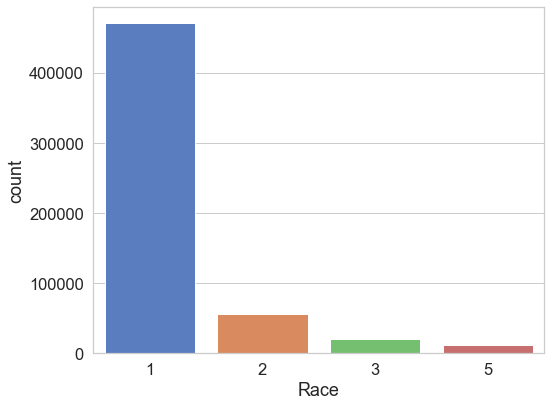

In [68]:
### Countplot of Race variable 
### From here we can find out that majority of claims are from Race 1
fig=plt.figure(figsize=(8,6))
sns.countplot(Train_Patient_data['Race'])
fig.tight_layout()

In [69]:
### Now in Race column we do 'one hot encoding' so that ranking of values doesn't occur here 

from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
x = onehotencoder.fit_transform(Train_Patient_data.Race.values.reshape(-1, 1)).toarray()

In [70]:
df_OneHot = pd.DataFrame(x, columns = ["Race_"+str(int(i)) for i in range(1,5)]) 
df_OneHot

,Race_1,Race_2,Race_3,Race_4
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
558206,1.0,0.0,0.0,0.0
558207,1.0,0.0,0.0,0.0
558208,1.0,0.0,0.0,0.0
558209,1.0,0.0,0.0,0.0


In [71]:
df_OneHot.drop('Race_1',axis=1,inplace=True) ## Drop the first column "Race_1" this we need to drop when we do oneHotEncoding
df_OneHot

,Race_2,Race_3,Race_4
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
558206,0.0,0.0,0.0
558207,0.0,0.0,0.0
558208,0.0,0.0,0.0
558209,0.0,0.0,0.0


In [72]:
## Concatenation of dataframe "df_oneHot" that we created above in our main dataset

Train_Patient_data = pd.concat([Train_Patient_data, df_OneHot], axis=1)


Train_Patient_data.drop(['Race'], axis=1,inplace=True)  #So now we do not need this race column so we are droping this also 

In [73]:
Train_Patient_data['RenalDiseaseIndicator'].describe()

count     558211
unique         2
top            0
freq      448363
Name: RenalDiseaseIndicator, dtype: object

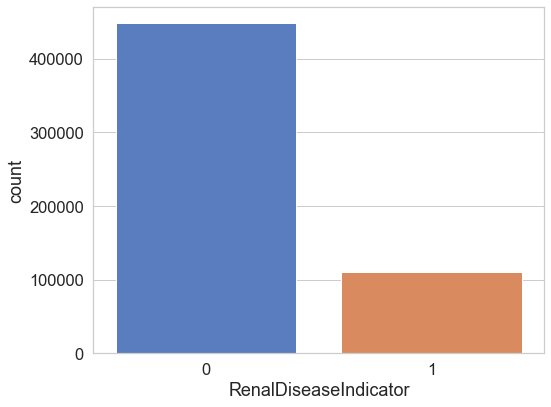

In [74]:
## Countplot of "RenalDiseaseIndicator" variable from here we can findout that maximu disease doesn't have any RenalDisease
fig=plt.figure(figsize=(8,6))
sns.countplot(Train_Patient_data['RenalDiseaseIndicator'])
fig.tight_layout()

In [75]:
Train_Patient_data['RenalDiseaseIndicator']=Train_Patient_data.RenalDiseaseIndicator.astype(int) # Change of datatype from object to int


Train_Patient_data['RenalDiseaseIndicator'].describe()

count    558211.000000
mean          0.196786
std           0.397569
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: RenalDiseaseIndicator, dtype: float64

In [76]:
Train_Patient_data[['State','County']].describe()

,State,County
count,558211.000000,558211.000000
mean,25.446969,378.588195
std,15.192784,265.215531
min,1.000000,0.000000
25%,11.000000,150.000000
50%,24.000000,350.000000
75%,38.000000,570.000000
max,54.000000,999.000000


In [77]:
#Find out which state has maximum count of claims

state_count=Train_Patient_data['State'].value_counts()
state_count=state_count[:20]
state_count

5     51350
10    39073
33    35024
45    34022
14    24417
39    24251
23    21343
36    21291
34    18905
11    17003
31    15940
49    14997
44    14418
15    14213
22    13624
26    12911
50    11740
21    11261
42    10491
18    10322
Name: State, dtype: int64

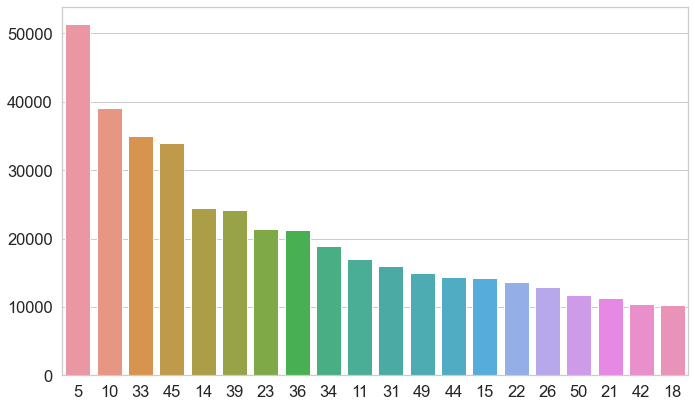

In [78]:
##Count plot of top 20 states which have maximum claims  

## from here we can see that state code 5 has maximum number of claims 

fig=plt.figure(figsize=(10,6))
sns.barplot(state_count.index,state_count.values,order=state_count.index)
fig.tight_layout()

In [79]:
#Find out which County has maximum count of claims
county_count=Train_Patient_data['County'].value_counts()
county_count=county_count[:20]
county_count

200    15957
10     13982
20     12632
470    12278
60     11995
400    11697
0      11481
90     11086
160    10533
150     9687
490     9487
590     9227
310     9027
141     8995
250     8384
130     8283
620     8170
290     8142
170     8017
50      7934
Name: County, dtype: int64

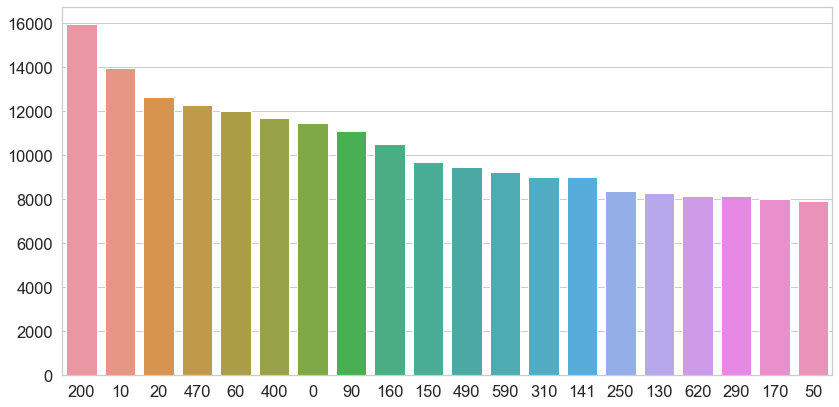

In [80]:
##Count plot of top 20 County which have maximum claims  

## from here we can see that County code 200 has maximum number of claims 


fig=plt.figure(figsize=(12,6))
sns.barplot(county_count.index,county_count.values,order=county_count.index)
fig.tight_layout()

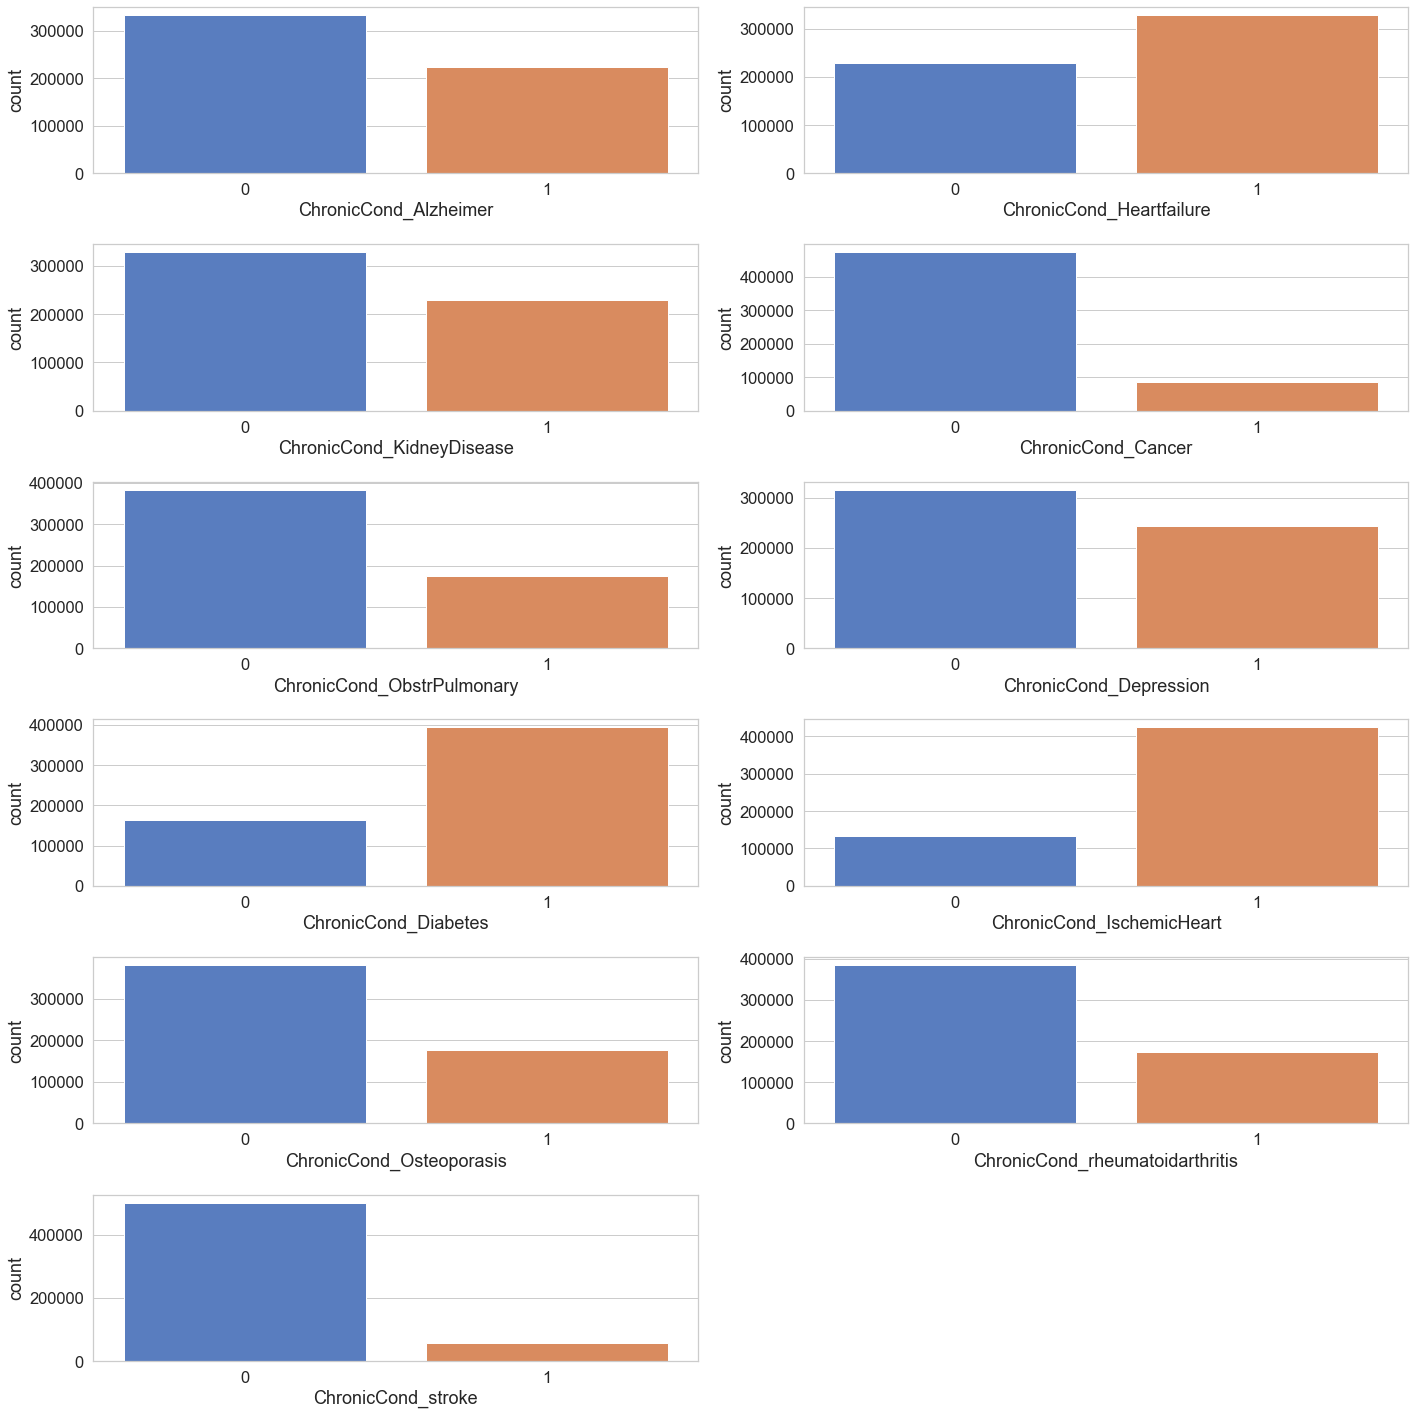

In [81]:
## Visulization of ChronicCond Variables 

## From this we can findout that how many claims has ChronicCond diseases, for eg: In ChronicCond_Alzheimer more than 3 lacs claims doesn't have this and remaining claims approx( 2 lacs) have ChronicCond_Alzheimer

fig=plt.figure(figsize=(20,20))

for col in range(1,12):
    plt.subplot(6,2,col)
    sns.countplot(Train_Patient_data.iloc[:,37+col])
    
fig.tight_layout()

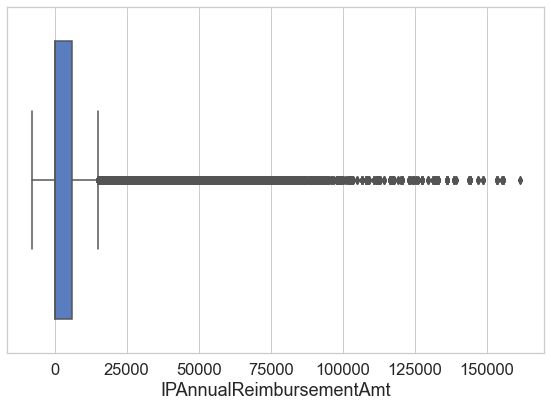

In [82]:
## Boxplot of "IPAnnualReimbursementAmt" and we can see in this boxplot data is not normally distributed and it is left skewed 

fig=plt.figure(figsize=(8,6))
sns.boxplot(Train_Patient_data['IPAnnualReimbursementAmt'])
fig.tight_layout()

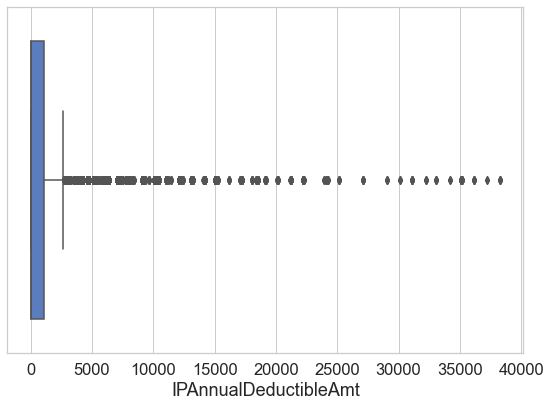

In [83]:
## Boxplot of "IPAnnualDeductibleAmt" and we can see in this boxplot data is not normally distributed and it is left skewed


fig=plt.figure(figsize=(8,6))
sns.boxplot(Train_Patient_data['IPAnnualDeductibleAmt'])
fig.tight_layout()

### Handling Missing values and add new features in Test_Patient_data

In [84]:
Test_Patient_data.isnull().sum()

BeneID                                  0
ClaimID                                 0
ClaimStartDt                            0
ClaimEndDt                              0
Provider                                0
InscClaimAmtReimbursed                  0
AttendingPhysician                    347
OperatingPhysician                 108199
OtherPhysician                      86760
AdmissionDt                        125841
ClmAdmitDiagnosisCode              100036
DeductibleAmtPaid                     196
DischargeDt                        125841
DiagnosisGroupCode                 125841
ClmDiagnosisCode_1                   2578
ClmDiagnosisCode_2                  47785
ClmDiagnosisCode_3                  76744
ClmDiagnosisCode_4                  95775
ClmDiagnosisCode_5                 108594
ClmDiagnosisCode_6                 115232
ClmDiagnosisCode_7                 119607
ClmDiagnosisCode_8                 122670
ClmDiagnosisCode_9                 125516
ClmDiagnosisCode_10               

In [85]:
## We are replacing these columns value with 0 and 1 where we have value we are replacing it with 1 and in place of null value we replace it with 0.


Test_Patient_data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(Test_Patient_data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']].isnull(), 0, 1)

Test_Patient_data['N_Types_Physicians'] = Test_Patient_data['AttendingPhysician'] +  Test_Patient_data['OperatingPhysician'] + Test_Patient_data['OtherPhysician']

In [86]:
Test_Patient_data['IsDiagnosisCode'] = np.where(Test_Patient_data.DiagnosisGroupCode.notnull(), 1, 0)
Test_Patient_data = Test_Patient_data.drop(['DiagnosisGroupCode'], axis = 1)

In [87]:
Test_Patient_data.isnull().sum()

BeneID                                  0
ClaimID                                 0
ClaimStartDt                            0
ClaimEndDt                              0
Provider                                0
InscClaimAmtReimbursed                  0
AttendingPhysician                      0
OperatingPhysician                      0
OtherPhysician                          0
AdmissionDt                        125841
ClmAdmitDiagnosisCode              100036
DeductibleAmtPaid                     196
DischargeDt                        125841
ClmDiagnosisCode_1                   2578
ClmDiagnosisCode_2                  47785
ClmDiagnosisCode_3                  76744
ClmDiagnosisCode_4                  95775
ClmDiagnosisCode_5                 108594
ClmDiagnosisCode_6                 115232
ClmDiagnosisCode_7                 119607
ClmDiagnosisCode_8                 122670
ClmDiagnosisCode_9                 125516
ClmDiagnosisCode_10                134242
ClmProcedureCode_1                

In [88]:
Test_Patient_data['DeductibleAmtPaid'].describe()

count    135196.000000
mean         76.499194
std         270.779562
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1068.000000
Name: DeductibleAmtPaid, dtype: float64

In [89]:
Test_Patient_data['DeductibleAmtPaid'].fillna(0,inplace=True)

Test_Patient_data['IsDeductibleAmtPaid']=np.where(Test_Patient_data['DeductibleAmtPaid']==0,0,1) 


Test_Patient_data['IsDeductibleAmtPaid'].value_counts()

0    120907
1     14485
Name: IsDeductibleAmtPaid, dtype: int64

In [90]:
Test_Patient_data['AdmitForDays'].isnull().sum()

125841

In [91]:
Test_Patient_data['AdmitForDays'].fillna(0,inplace=True)

In [92]:
Test_Patient_data.Gender.describe()

count    135392.000000
mean          1.576231
std           0.494157
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: Gender, dtype: float64

In [93]:
Test_Patient_data['Gender']=Test_Patient_data['Gender'].replace(2,0)

In [94]:
Test_Patient_data['Race'].describe()

count    135392.000000
mean          1.240605
std           0.695578
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           5.000000
Name: Race, dtype: float64

In [95]:
onehotencoder = OneHotEncoder()
x = onehotencoder.fit_transform(Test_Patient_data.Race.values.reshape(-1, 1)).toarray()

df_test_OneHot = pd.DataFrame(x, columns = ["Race_"+str(int(i)) for i in range(1,5)]) 
df_test_OneHot

,Race_1,Race_2,Race_3,Race_4
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
135387,1.0,0.0,0.0,0.0
135388,1.0,0.0,0.0,0.0
135389,1.0,0.0,0.0,0.0
135390,1.0,0.0,0.0,0.0


In [96]:
df_test_OneHot.drop('Race_1',axis=1,inplace=True)


Test_Patient_data = pd.concat([Test_Patient_data, df_test_OneHot], axis=1)

#droping the country column 

In [97]:
Test_Patient_data.drop(['Race'], axis=1,inplace=True)

In [98]:
Test_Patient_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135392 entries, 0 to 135391
Data columns (total 61 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   BeneID                           135392 non-null  object        
 1   ClaimID                          135392 non-null  object        
 2   ClaimStartDt                     135392 non-null  object        
 3   ClaimEndDt                       135392 non-null  object        
 4   Provider                         135392 non-null  object        
 5   InscClaimAmtReimbursed           135392 non-null  int64         
 6   AttendingPhysician               135392 non-null  int64         
 7   OperatingPhysician               135392 non-null  int64         
 8   OtherPhysician                   135392 non-null  int64         
 9   AdmissionDt                      9551 non-null    datetime64[ns]
 10  ClmAdmitDiagnosisCode            35356 non-n

In [99]:
Test_Patient_data['RenalDiseaseIndicator'].describe()

count     135392
unique         2
top            0
freq      109143
Name: RenalDiseaseIndicator, dtype: object

In [100]:
Test_Patient_data['RenalDiseaseIndicator']=Test_Patient_data.RenalDiseaseIndicator.astype(int)

In [101]:
Test_Patient_data[ClmProcedure_vars].describe()

,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
count,5467.000000,1263.000000,225.000000,29.000000,2.000000,0.0
mean,5905.430766,4138.790182,4182.213333,4509.931034,7055.500000,NaN
std,3057.976988,2042.016095,2165.057828,2571.379659,4124.553855,NaN
min,14.000000,42.000000,185.000000,260.000000,4139.000000,NaN
25%,3891.000000,2749.000000,2724.000000,3320.000000,5597.250000,NaN
50%,5369.000000,4019.000000,4019.000000,4263.000000,7055.500000,NaN
75%,8741.000000,4439.000000,5121.000000,5781.000000,8513.750000,NaN
max,9999.000000,9998.000000,9984.000000,9971.000000,9972.000000,NaN


In [102]:
# We count the number of procedures for each claim
Test_Patient_data['N_Procedure'] = N_unique_values(Test_Patient_data[ClmProcedure_vars])

In [103]:
Test_Patient_data['N_Procedure'].value_counts()

0    129925
1      4204
2      1038
3       196
4        27
5         2
Name: N_Procedure, dtype: int64

In [104]:
# We count the number of CLMDiagnosisCode for each claim and store these value in a new variable

Test_Patient_data['N_UniqueDiagnosis_Claims'] = N_unique_values(Test_Patient_data[ClmDiagnosisCode_vars])

Test_Patient_data['N_UniqueDiagnosis_Claims'].value_counts()

1     37149
2     32041
3     20966
4     13979
5      7368
10     5193
9      5095
6      4696
7      3367
8      2754
0      2086
11      698
Name: N_UniqueDiagnosis_Claims, dtype: int64

In [105]:
print('\033[1m'+"Train Patient Dataset"+ "\033[0m")

print(Train_Patient_data.info())

print('\033[1m'+"Test Patient Dataset"+ "\033[0m")

print(Test_Patient_data.info())

Train Patient Dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 63 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   BeneID                           558211 non-null  object        
 1   ClaimID                          558211 non-null  object        
 2   ClaimStartDt                     558211 non-null  object        
 3   ClaimEndDt                       558211 non-null  object        
 4   Provider                         558211 non-null  object        
 5   InscClaimAmtReimbursed           558211 non-null  int64         
 6   AttendingPhysician               558211 non-null  int64         
 7   OperatingPhysician               558211 non-null  int64         
 8   OtherPhysician                   558211 non-null  int64         
 9   AdmissionDt                      40474 non-null   datetime64[ns]
 10  ClmAdmitDiagnosisCode 

### Merging of Train and Test dataframe with Train_Patient_data and Test_Patient_data respectively to create a Final Dataframe for Train and Test for modelling

In [106]:
### Count number of records
## From here we get the count of BeneID and ClaimId for each provider

## For Train 
Train_Count = Train_Patient_data[['BeneID', 'ClaimID']].groupby(Train_Patient_data['Provider']).nunique().reset_index()
Train_Count.rename(columns={'BeneID':'BeneID_count','ClaimID':'ClaimID_count'},inplace=True)


## For Test
Test_Count = Test_Patient_data[['BeneID', 'ClaimID']].groupby(Test_Patient_data['Provider']).nunique().reset_index()
Test_Count.rename(columns={'BeneID':'BeneID_count','ClaimID':'ClaimID_count'},inplace=True)

In [107]:
Train_Count

,Provider,BeneID_count,ClaimID_count
0,PRV51001,24,25
1,PRV51003,117,132
2,PRV51004,138,149
3,PRV51005,495,1165
4,PRV51007,58,72
...,...,...,...
5405,PRV57759,24,28
5406,PRV57760,9,22
5407,PRV57761,67,82
5408,PRV57762,1,1


In [108]:
Test_Count

,Provider,BeneID_count,ClaimID_count
0,PRV51002,169,205
1,PRV51006,81,102
2,PRV51009,30,39
3,PRV51010,25,38
4,PRV51018,146,190
...,...,...,...
1348,PRV57713,10,11
1349,PRV57726,8,8
1350,PRV57745,2,2
1351,PRV57749,45,49


In [109]:
Train_Data_Sum = Train_Patient_data.groupby(['Provider'], as_index = False)[['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'RenalDiseaseIndicator', 
                                                     'AttendingPhysician','OperatingPhysician','OtherPhysician','AdmitForDays',
                                                    'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure','ChronicCond_Cancer', 
                                                    'ChronicCond_KidneyDisease', 'ChronicCond_ObstrPulmonary',
                                                   'ChronicCond_Depression','ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',   
                                                    'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                                                    'ChronicCond_stroke', 'IPAnnualReimbursementAmt','IPAnnualDeductibleAmt',
                                                    'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'WhetherDead',
                                                    'N_Types_Physicians','IsDiagnosisCode', 'N_Procedure', 'N_UniqueDiagnosis_Claims']].sum()

Test_Data_Sum = Test_Patient_data.groupby(['Provider'], as_index = False)[['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'RenalDiseaseIndicator', 
                                                     'AttendingPhysician','OperatingPhysician','OtherPhysician','AdmitForDays',
                                                    'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure','ChronicCond_Cancer', 
                                                    'ChronicCond_KidneyDisease', 'ChronicCond_ObstrPulmonary',
                                                   'ChronicCond_Depression','ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',   
                                                    'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                                                    'ChronicCond_stroke', 'IPAnnualReimbursementAmt','IPAnnualDeductibleAmt',
                                                    'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'WhetherDead',
                                                    'N_Types_Physicians','IsDiagnosisCode', 'N_Procedure', 'N_UniqueDiagnosis_Claims']].sum()

In [111]:
Train_Data_Sum

,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmitForDays,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,WhetherDead,N_Types_Physicians,IsDiagnosisCode,N_Procedure,N_UniqueDiagnosis_Claims
0,PRV51001,104640,5340.0,8,25,5,10,30.0,15,19,...,6,440150,22428,65380,11598,0.0,40,5,3,91
1,PRV51003,605670,66286.0,29,132,45,25,382.0,56,80,...,12,999000,122948,353520,97300,1.0,202,62,48,761
2,PRV51004,52170,310.0,23,149,27,63,0.0,64,88,...,17,648430,64808,327040,92790,1.0,239,0,0,410
3,PRV51005,280910,3700.0,259,1163,222,478,0.0,426,680,...,124,4221950,441724,2457840,741323,4.0,1863,0,0,3246
4,PRV51007,33710,3264.0,11,72,12,26,19.0,26,40,...,12,219600,32040,124540,33820,1.0,110,3,1,231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,10640,130.0,5,28,1,12,0.0,14,20,...,4,110940,12816,90770,24830,0.0,41,0,0,61
5406,PRV57760,4770,0.0,0,22,6,9,0.0,3,11,...,0,61280,9612,32840,17720,0.0,37,0,0,59
5407,PRV57761,18470,370.0,23,82,14,36,0.0,36,56,...,10,576180,48060,240130,58000,1.0,132,0,0,235
5408,PRV57762,1900,0.0,0,1,0,0,0.0,0,0,...,0,15000,1068,2540,400,0.0,1,0,0,2


In [112]:
Test_Data_Sum

,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmitForDays,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,WhetherDead,N_Types_Physicians,IsDiagnosisCode,N_Procedure,N_UniqueDiagnosis_Claims
0,PRV51002,53790,380.0,32,205,30,77,0.0,79,108,...,19,1062090,112392,480740,138980,3.0,312,0,0,584
1,PRV51006,30720,0.0,10,102,24,38,0.0,35,69,...,8,384290,48924,244970,61800,0.0,164,0,0,306
2,PRV51009,27230,1238.0,12,38,12,10,8.0,8,17,...,3,117160,9612,95200,25210,0.0,60,2,3,127
3,PRV51010,64580,5340.0,5,38,9,10,29.0,21,23,...,5,200200,20292,67480,25230,0.0,57,6,3,128
4,PRV51018,61620,670.0,41,190,30,72,0.0,73,109,...,13,900400,101460,534460,156960,2.0,292,0,0,541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348,PRV57713,860,0.0,2,11,0,6,0.0,6,7,...,0,5000,1068,15710,5510,0.0,17,0,0,21
1349,PRV57726,1590,0.0,0,8,0,3,0.0,4,5,...,0,105000,2136,21210,9010,0.0,11,0,0,23
1350,PRV57745,510,0.0,1,2,0,2,0.0,1,2,...,0,20060,2136,7430,1420,0.0,4,0,0,4
1351,PRV57749,9980,370.0,9,49,8,21,0.0,18,22,...,4,172930,17088,85060,24780,2.0,78,0,0,114


In [113]:
## Here we are calculating the mean of values for some variables for each unique provider.

Train_Data_Mean=round(Train_Patient_data.groupby(['Provider'], as_index = False)[['NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
                                                                            'Age']].mean())


Test_Data_Mean=round(Test_Patient_data.groupby(['Provider'], as_index = False)[['NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
                                                                            'Age']].mean())

In [114]:
Train_Data_Mean

,Provider,NoOfMonths_PartACov,NoOfMonths_PartBCov,Age
0,PRV51001,12.0,12.0,87.0
1,PRV51003,12.0,12.0,78.0
2,PRV51004,12.0,12.0,80.0
3,PRV51005,12.0,12.0,78.0
4,PRV51007,12.0,12.0,77.0
...,...,...,...,...
5405,PRV57759,12.0,12.0,82.0
5406,PRV57760,12.0,12.0,69.0
5407,PRV57761,12.0,12.0,80.0
5408,PRV57762,12.0,12.0,76.0


In [115]:
## Merging of Train Datasets
Train_df=pd.merge(Train_Count,Train_Data_Sum,on='Provider',how='left').\
                merge(Train_Data_Mean,on='Provider',how='left').\
                merge(Train,on='Provider',how='left')

## Merging of Test Datasets

Test_df=pd.merge(Test_Count,Test_Data_Sum,on='Provider',how='left').\
                merge(Test_Data_Mean,on='Provider',how='left').\
                merge(Test,on='Provider',how='left')

In [117]:
Train_df #Target column PotentialFraud is avaialble here

,Provider,BeneID_count,ClaimID_count,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmitForDays,...,OPAnnualDeductibleAmt,WhetherDead,N_Types_Physicians,IsDiagnosisCode,N_Procedure,N_UniqueDiagnosis_Claims,NoOfMonths_PartACov,NoOfMonths_PartBCov,Age,PotentialFraud
0,PRV51001,24,25,104640,5340.0,8,25,5,10,30.0,...,11598,0.0,40,5,3,91,12.0,12.0,87.0,No
1,PRV51003,117,132,605670,66286.0,29,132,45,25,382.0,...,97300,1.0,202,62,48,761,12.0,12.0,78.0,Yes
2,PRV51004,138,149,52170,310.0,23,149,27,63,0.0,...,92790,1.0,239,0,0,410,12.0,12.0,80.0,No
3,PRV51005,495,1165,280910,3700.0,259,1163,222,478,0.0,...,741323,4.0,1863,0,0,3246,12.0,12.0,78.0,Yes
4,PRV51007,58,72,33710,3264.0,11,72,12,26,19.0,...,33820,1.0,110,3,1,231,12.0,12.0,77.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,24,28,10640,130.0,5,28,1,12,0.0,...,24830,0.0,41,0,0,61,12.0,12.0,82.0,No
5406,PRV57760,9,22,4770,0.0,0,22,6,9,0.0,...,17720,0.0,37,0,0,59,12.0,12.0,69.0,No
5407,PRV57761,67,82,18470,370.0,23,82,14,36,0.0,...,58000,1.0,132,0,0,235,12.0,12.0,80.0,No
5408,PRV57762,1,1,1900,0.0,0,1,0,0,0.0,...,400,0.0,1,0,0,2,12.0,12.0,76.0,No


In [118]:
Test_df #Target column PotentialFraud is not avaialble here

,Provider,BeneID_count,ClaimID_count,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmitForDays,...,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,WhetherDead,N_Types_Physicians,IsDiagnosisCode,N_Procedure,N_UniqueDiagnosis_Claims,NoOfMonths_PartACov,NoOfMonths_PartBCov,Age
0,PRV51002,169,205,53790,380.0,32,205,30,77,0.0,...,480740,138980,3.0,312,0,0,584,12.0,12.0,80.0
1,PRV51006,81,102,30720,0.0,10,102,24,38,0.0,...,244970,61800,0.0,164,0,0,306,12.0,12.0,83.0
2,PRV51009,30,39,27230,1238.0,12,38,12,10,8.0,...,95200,25210,0.0,60,2,3,127,12.0,12.0,78.0
3,PRV51010,25,38,64580,5340.0,5,38,9,10,29.0,...,67480,25230,0.0,57,6,3,128,12.0,12.0,83.0
4,PRV51018,146,190,61620,670.0,41,190,30,72,0.0,...,534460,156960,2.0,292,0,0,541,12.0,12.0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348,PRV57713,10,11,860,0.0,2,11,0,6,0.0,...,15710,5510,0.0,17,0,0,21,12.0,12.0,87.0
1349,PRV57726,8,8,1590,0.0,0,8,0,3,0.0,...,21210,9010,0.0,11,0,0,23,12.0,12.0,76.0
1350,PRV57745,2,2,510,0.0,1,2,0,2,0.0,...,7430,1420,0.0,4,0,0,4,12.0,12.0,85.0
1351,PRV57749,45,49,9980,370.0,9,49,8,21,0.0,...,85060,24780,2.0,78,0,0,114,12.0,12.0,79.0


In [119]:
Train_df.isnull().sum() ## No null value is present in this datase

Provider                           0
BeneID_count                       0
ClaimID_count                      0
InscClaimAmtReimbursed             0
DeductibleAmtPaid                  0
RenalDiseaseIndicator              0
AttendingPhysician                 0
OperatingPhysician                 0
OtherPhysician                     0
AdmitForDays                       0
ChronicCond_Alzheimer              0
ChronicCond_Heartfailure           0
ChronicCond_Cancer                 0
ChronicCond_KidneyDisease          0
ChronicCond_ObstrPulmonary         0
ChronicCond_Depression             0
ChronicCond_Diabetes               0
ChronicCond_IschemicHeart          0
ChronicCond_Osteoporasis           0
ChronicCond_rheumatoidarthritis    0
ChronicCond_stroke                 0
IPAnnualReimbursementAmt           0
IPAnnualDeductibleAmt              0
OPAnnualReimbursementAmt           0
OPAnnualDeductibleAmt              0
WhetherDead                        0
N_Types_Physicians                 0
I

In [120]:
#In Train Dataset Target variable PotentialFraud has value in category i.e "Yes" and "No" need to replace with 1 and 0.

Train_df['PotentialFraud']=np.where(Train_df.PotentialFraud == "Yes", 1, 0)

In [121]:
Train_df

,Provider,BeneID_count,ClaimID_count,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmitForDays,...,OPAnnualDeductibleAmt,WhetherDead,N_Types_Physicians,IsDiagnosisCode,N_Procedure,N_UniqueDiagnosis_Claims,NoOfMonths_PartACov,NoOfMonths_PartBCov,Age,PotentialFraud
0,PRV51001,24,25,104640,5340.0,8,25,5,10,30.0,...,11598,0.0,40,5,3,91,12.0,12.0,87.0,0
1,PRV51003,117,132,605670,66286.0,29,132,45,25,382.0,...,97300,1.0,202,62,48,761,12.0,12.0,78.0,1
2,PRV51004,138,149,52170,310.0,23,149,27,63,0.0,...,92790,1.0,239,0,0,410,12.0,12.0,80.0,0
3,PRV51005,495,1165,280910,3700.0,259,1163,222,478,0.0,...,741323,4.0,1863,0,0,3246,12.0,12.0,78.0,1
4,PRV51007,58,72,33710,3264.0,11,72,12,26,19.0,...,33820,1.0,110,3,1,231,12.0,12.0,77.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,24,28,10640,130.0,5,28,1,12,0.0,...,24830,0.0,41,0,0,61,12.0,12.0,82.0,0
5406,PRV57760,9,22,4770,0.0,0,22,6,9,0.0,...,17720,0.0,37,0,0,59,12.0,12.0,69.0,0
5407,PRV57761,67,82,18470,370.0,23,82,14,36,0.0,...,58000,1.0,132,0,0,235,12.0,12.0,80.0,0
5408,PRV57762,1,1,1900,0.0,0,1,0,0,0.0,...,400,0.0,1,0,0,2,12.0,12.0,76.0,0


<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

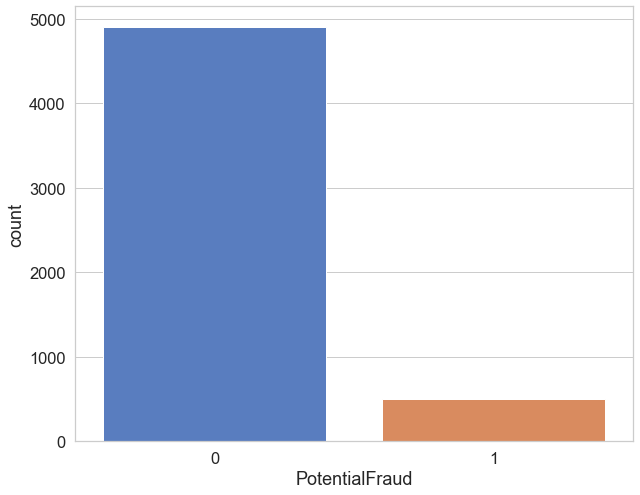

In [122]:
# Here we can the count of Dependent variable values 
plt.figure(figsize=(10,8))
sns.countplot(Train_df.PotentialFraud)

Text(0, 0.5, 'BeneID_count')

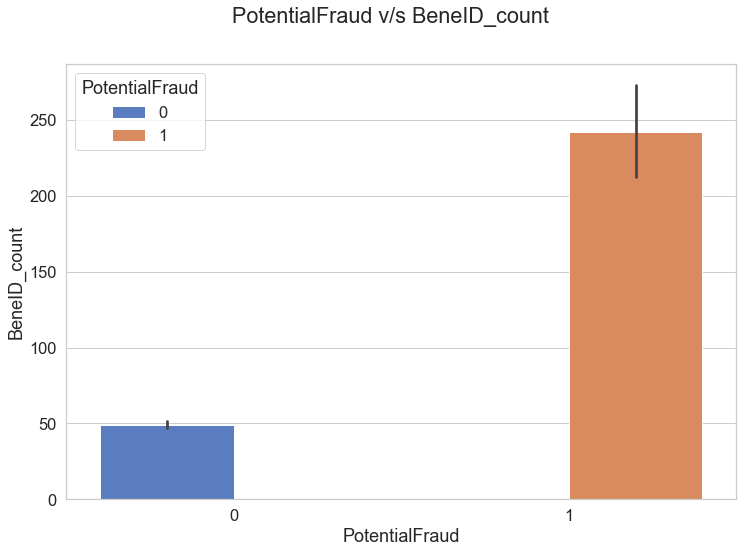

In [123]:
## Here we can se the barplot of PotentialFraud v/s BeneID_Count and here bar shows mean of BeneID_Count for Potential Fraud value 1 and 0
## From this barplot we can conclude that there is a Potential Fraud when the BeneID_Count is more as its mean is more as shown.

plt.figure(figsize=(12,8))
sns.barplot(Train_df["PotentialFraud"],Train_df["BeneID_count"], hue=Train_df["PotentialFraud"])
plt.suptitle('PotentialFraud v/s BeneID_count')
plt.xlabel('PotentialFraud')
plt.ylabel('BeneID_count')

In [124]:
### As we can see Fraudulant claims have higher number of Beneficiary ID as they tend to commit fraud with multiple beneficiary id.

<AxesSubplot:xlabel='PotentialFraud', ylabel='ClaimID_count'>

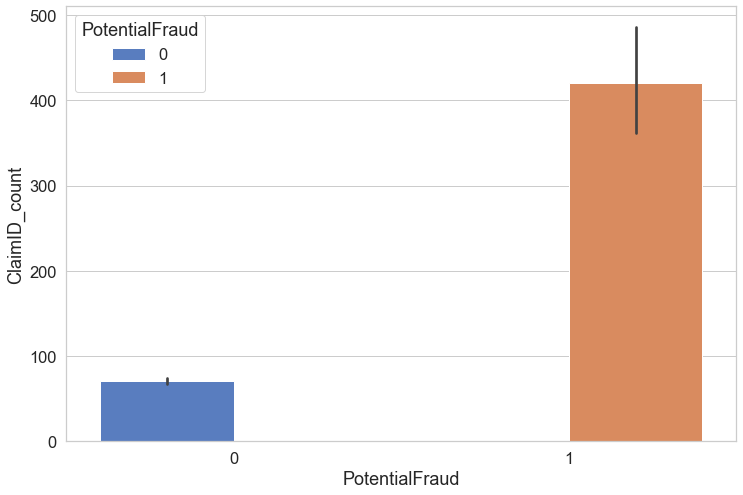

In [125]:
## Here we can se the barplot of PotentialFraud v/s ClaimID_Count and here bar shows mean of ClaimID_Count for Potential Fraud value 1 and 0
## From this barplot we can conclude that there is a Potential Fraud when the ClaimID_Count is more as its mean is more as shown.

plt.figure(figsize=(12,8))
sns.barplot(Train_df["PotentialFraud"],Train_df["ClaimID_count"], hue=Train_df["PotentialFraud"])

<AxesSubplot:xlabel='PotentialFraud', ylabel='InscClaimAmtReimbursed'>

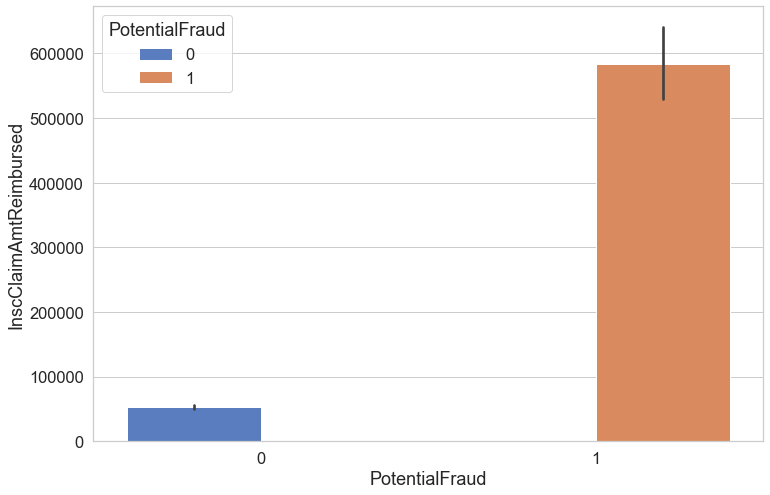

In [126]:
## Here we can se the barplot of PotentialFraud v/s InscClaimAmtReimbursed and here bar shows mean of InscClaimAmtReimbursed for Potential Fraud value 1 and 0
## From this barplot we can conclude that there is a Potential Fraud when the InscClaimAmtReimbursed is more as its mean is more as shown.

plt.figure(figsize=(12,8))

sns.barplot(Train_df["PotentialFraud"],Train_df["InscClaimAmtReimbursed"], hue=Train_df["PotentialFraud"])

<AxesSubplot:xlabel='PotentialFraud', ylabel='DeductibleAmtPaid'>

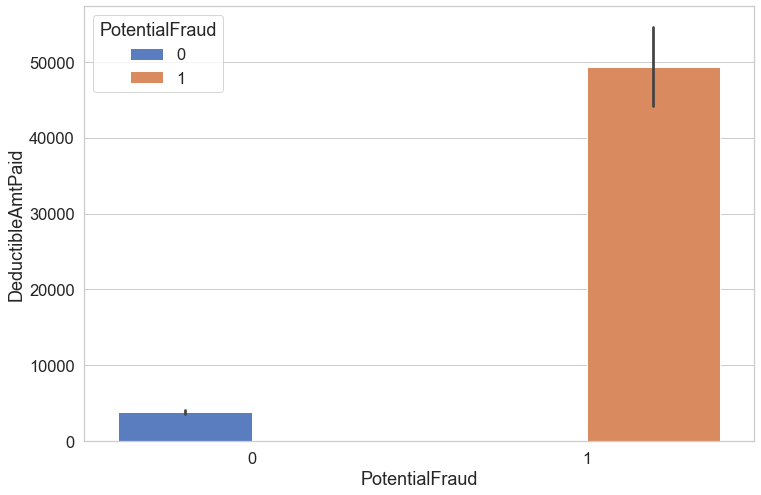

In [127]:
plt.figure(figsize=(12,8))

sns.barplot(Train_df["PotentialFraud"],Train_df["DeductibleAmtPaid"], hue=Train_df["PotentialFraud"])

<AxesSubplot:xlabel='PotentialFraud', ylabel='RenalDiseaseIndicator'>

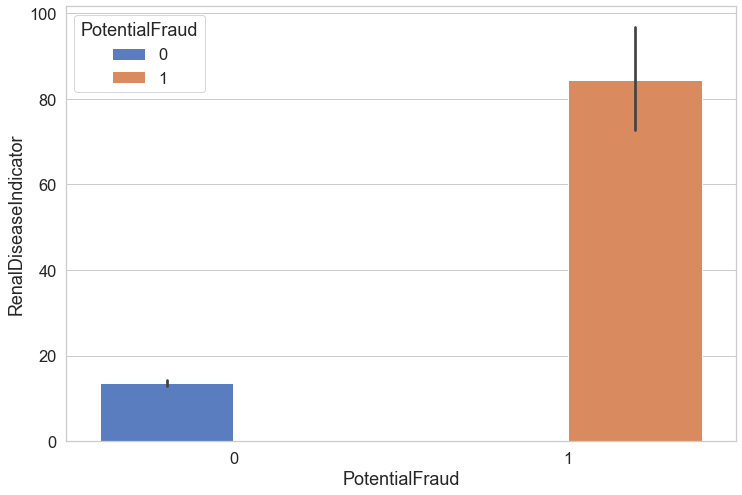

In [128]:
plt.figure(figsize=(12,8))
sns.barplot(Train_df["PotentialFraud"],Train_df["RenalDiseaseIndicator"], hue=Train_df["PotentialFraud"])

<AxesSubplot:xlabel='PotentialFraud', ylabel='AdmitForDays'>

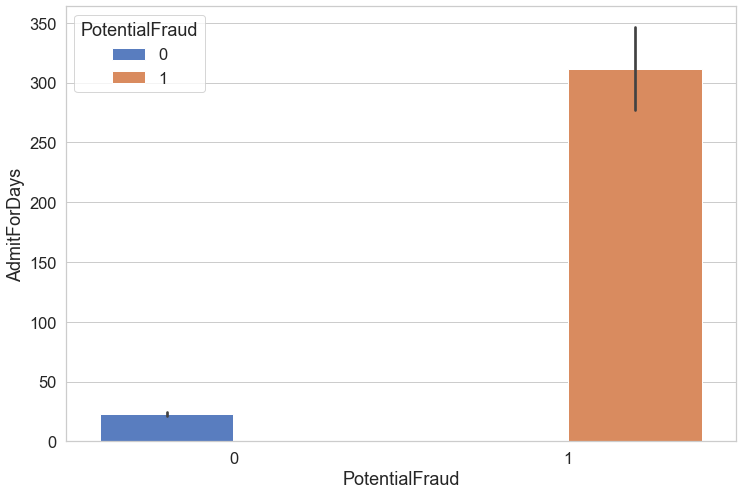

In [129]:
plt.figure(figsize=(12,8))
sns.barplot(Train_df["PotentialFraud"],Train_df["AdmitForDays"], hue=Train_df["PotentialFraud"])

<AxesSubplot:xlabel='PotentialFraud', ylabel='WhetherDead'>

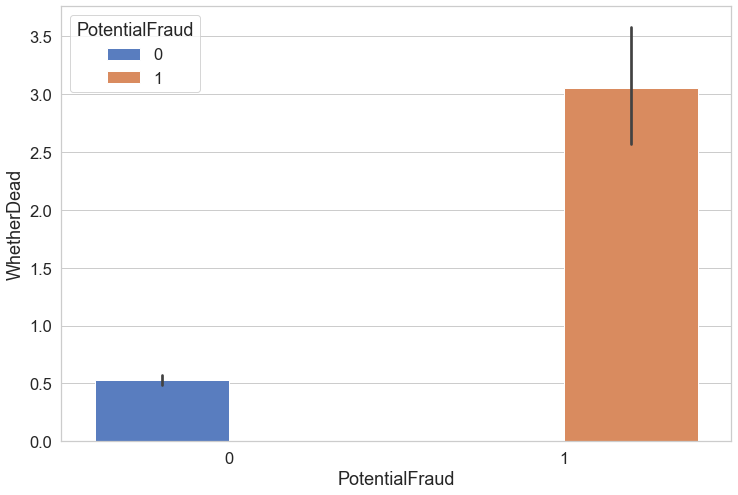

In [129]:
plt.figure(figsize=(12,8))
sns.barplot(Train_df["PotentialFraud"],Train_df["WhetherDead"], hue=Train_df["PotentialFraud"])

### In category 0, the bar is between 0 and 1 because there are some people who are dead and some are alive, but in category 1 the bar has gone above 3 that means fraudulant claims are more likely to happen where people are dead.

<AxesSubplot:>

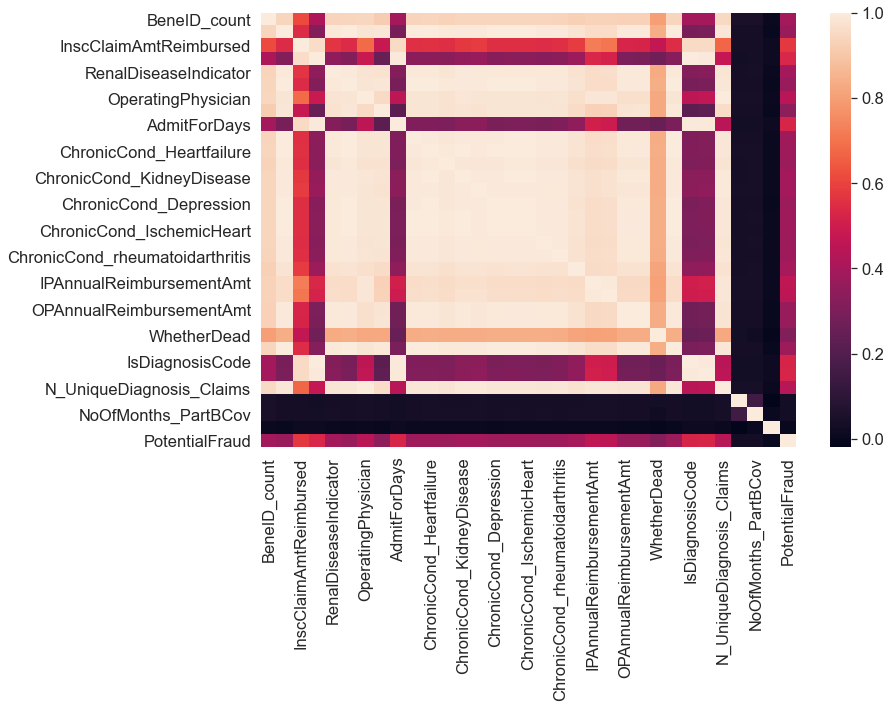

In [130]:
plt.figure(figsize=(12,8))
Train_corr=Train_df.corr()
sns.heatmap(Train_corr)

In [131]:
Train_corr=Train_df.corr()
Train_corr['PotentialFraud']

BeneID_count                       0.393531
ClaimID_count                      0.374197
InscClaimAmtReimbursed             0.575558
DeductibleAmtPaid                  0.532070
RenalDiseaseIndicator              0.391002
AttendingPhysician                 0.374253
OperatingPhysician                 0.445086
OtherPhysician                     0.342673
AdmitForDays                       0.526338
ChronicCond_Alzheimer              0.380344
ChronicCond_Heartfailure           0.384131
ChronicCond_Cancer                 0.376945
ChronicCond_KidneyDisease          0.394239
ChronicCond_ObstrPulmonary         0.396191
ChronicCond_Depression             0.377411
ChronicCond_Diabetes               0.378881
ChronicCond_IschemicHeart          0.380093
ChronicCond_Osteoporasis           0.378274
ChronicCond_rheumatoidarthritis    0.380161
ChronicCond_stroke                 0.399206
IPAnnualReimbursementAmt           0.461978
IPAnnualDeductibleAmt              0.454921
OPAnnualReimbursementAmt        

### So from here we can see that Age, NoOfMonths_PartBCov and NoOfMonths_PartACov are not making any pattern/relationship with dependent variable 'PotentialFraud', hence we will not consider these variables in our model

### We will make a final dataset on which we will do modelling,In this dataset we keep only those variable which we will use in our machine learning modelling algorithms. So from our Train_df dataset we will remove all ID type variables like Provider,BeneID_count and ClaimID_count and also remove those variable which are not making any pattern with the dependent variable this we can see correlation matrix that is shown above

In [132]:
df_clf=Train_df.iloc[:,3:]
df_clf

,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmitForDays,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_Cancer,...,OPAnnualDeductibleAmt,WhetherDead,N_Types_Physicians,IsDiagnosisCode,N_Procedure,N_UniqueDiagnosis_Claims,NoOfMonths_PartACov,NoOfMonths_PartBCov,Age,PotentialFraud
0,104640,5340.0,8,25,5,10,30.0,15,19,5,...,11598,0.0,40,5,3,91,12.0,12.0,87.0,0
1,605670,66286.0,29,132,45,25,382.0,56,80,10,...,97300,1.0,202,62,48,761,12.0,12.0,78.0,1
2,52170,310.0,23,149,27,63,0.0,64,88,16,...,92790,1.0,239,0,0,410,12.0,12.0,80.0,0
3,280910,3700.0,259,1163,222,478,0.0,426,680,165,...,741323,4.0,1863,0,0,3246,12.0,12.0,78.0,1
4,33710,3264.0,11,72,12,26,19.0,26,40,12,...,33820,1.0,110,3,1,231,12.0,12.0,77.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,10640,130.0,5,28,1,12,0.0,14,20,4,...,24830,0.0,41,0,0,61,12.0,12.0,82.0,0
5406,4770,0.0,0,22,6,9,0.0,3,11,0,...,17720,0.0,37,0,0,59,12.0,12.0,69.0,0
5407,18470,370.0,23,82,14,36,0.0,36,56,14,...,58000,1.0,132,0,0,235,12.0,12.0,80.0,0
5408,1900,0.0,0,1,0,0,0.0,0,0,1,...,400,0.0,1,0,0,2,12.0,12.0,76.0,0


In [133]:
df_clf.drop(['NoOfMonths_PartACov','NoOfMonths_PartBCov','Age'],axis=1,inplace=True)

In [136]:
df_clf #This is final Trained Dataset

,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmitForDays,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_Cancer,...,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,WhetherDead,N_Types_Physicians,IsDiagnosisCode,N_Procedure,N_UniqueDiagnosis_Claims,PotentialFraud
0,104640,5340.0,8,25,5,10,30.0,15,19,5,...,440150,22428,65380,11598,0.0,40,5,3,91,0
1,605670,66286.0,29,132,45,25,382.0,56,80,10,...,999000,122948,353520,97300,1.0,202,62,48,761,1
2,52170,310.0,23,149,27,63,0.0,64,88,16,...,648430,64808,327040,92790,1.0,239,0,0,410,0
3,280910,3700.0,259,1163,222,478,0.0,426,680,165,...,4221950,441724,2457840,741323,4.0,1863,0,0,3246,1
4,33710,3264.0,11,72,12,26,19.0,26,40,12,...,219600,32040,124540,33820,1.0,110,3,1,231,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,10640,130.0,5,28,1,12,0.0,14,20,4,...,110940,12816,90770,24830,0.0,41,0,0,61,0
5406,4770,0.0,0,22,6,9,0.0,3,11,0,...,61280,9612,32840,17720,0.0,37,0,0,59,0
5407,18470,370.0,23,82,14,36,0.0,36,56,14,...,576180,48060,240130,58000,1.0,132,0,0,235,0
5408,1900,0.0,0,1,0,0,0.0,0,0,1,...,15000,1068,2540,400,0.0,1,0,0,2,0


In [135]:
Test_df  #This is final Trained Dataset

,Provider,BeneID_count,ClaimID_count,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmitForDays,...,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,WhetherDead,N_Types_Physicians,IsDiagnosisCode,N_Procedure,N_UniqueDiagnosis_Claims,NoOfMonths_PartACov,NoOfMonths_PartBCov,Age
0,PRV51002,169,205,53790,380.0,32,205,30,77,0.0,...,480740,138980,3.0,312,0,0,584,12.0,12.0,80.0
1,PRV51006,81,102,30720,0.0,10,102,24,38,0.0,...,244970,61800,0.0,164,0,0,306,12.0,12.0,83.0
2,PRV51009,30,39,27230,1238.0,12,38,12,10,8.0,...,95200,25210,0.0,60,2,3,127,12.0,12.0,78.0
3,PRV51010,25,38,64580,5340.0,5,38,9,10,29.0,...,67480,25230,0.0,57,6,3,128,12.0,12.0,83.0
4,PRV51018,146,190,61620,670.0,41,190,30,72,0.0,...,534460,156960,2.0,292,0,0,541,12.0,12.0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348,PRV57713,10,11,860,0.0,2,11,0,6,0.0,...,15710,5510,0.0,17,0,0,21,12.0,12.0,87.0
1349,PRV57726,8,8,1590,0.0,0,8,0,3,0.0,...,21210,9010,0.0,11,0,0,23,12.0,12.0,76.0
1350,PRV57745,2,2,510,0.0,1,2,0,2,0.0,...,7430,1420,0.0,4,0,0,4,12.0,12.0,85.0
1351,PRV57749,45,49,9980,370.0,9,49,8,21,0.0,...,85060,24780,2.0,78,0,0,114,12.0,12.0,79.0


In [137]:
def test(test_data):
    test_data=test_data.iloc[:,3:]
    test_data=test_data.drop(['NoOfMonths_PartACov','NoOfMonths_PartBCov','Age'],axis=1)
    return test_data

In [138]:
Test_data=test(Test_df)
Test_data ## In this target varaible is not there we need to predict this after we trained our model

,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmitForDays,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_Cancer,...,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,WhetherDead,N_Types_Physicians,IsDiagnosisCode,N_Procedure,N_UniqueDiagnosis_Claims
0,53790,380.0,32,205,30,77,0.0,79,108,25,...,19,1062090,112392,480740,138980,3.0,312,0,0,584
1,30720,0.0,10,102,24,38,0.0,35,69,15,...,8,384290,48924,244970,61800,0.0,164,0,0,306
2,27230,1238.0,12,38,12,10,8.0,8,17,1,...,3,117160,9612,95200,25210,0.0,60,2,3,127
3,64580,5340.0,5,38,9,10,29.0,21,23,7,...,5,200200,20292,67480,25230,0.0,57,6,3,128
4,61620,670.0,41,190,30,72,0.0,73,109,25,...,13,900400,101460,534460,156960,2.0,292,0,0,541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348,860,0.0,2,11,0,6,0.0,6,7,1,...,0,5000,1068,15710,5510,0.0,17,0,0,21
1349,1590,0.0,0,8,0,3,0.0,4,5,1,...,0,105000,2136,21210,9010,0.0,11,0,0,23
1350,510,0.0,1,2,0,2,0.0,1,2,1,...,0,20060,2136,7430,1420,0.0,4,0,0,4
1351,9980,370.0,9,49,8,21,0.0,18,22,6,...,4,172930,17088,85060,24780,2.0,78,0,0,114


In [139]:
#Split the dataset into Independent and Dependent Features

x=df_clf.drop("PotentialFraud",axis=1)
y=df_clf.PotentialFraud

In [140]:
print("Independent Variable shape:",x.shape)
print("Dependent Variable shape:",y.shape)

Independent Variable shape: (5410, 27)
Dependent Variable shape: (5410,)


In [141]:
### Train Test Split

x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=42)


print("Independent variables train:",x_train.shape)
print("Target variable train:",y_train.shape)
print("Independent variables test:",x_test.shape)
print("Target variables test:",y_test.shape)

Independent variables train: (3786, 27)
Target variable train: (3786,)
Independent variables test: (1624, 27)
Target variables test: (1624,)


<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

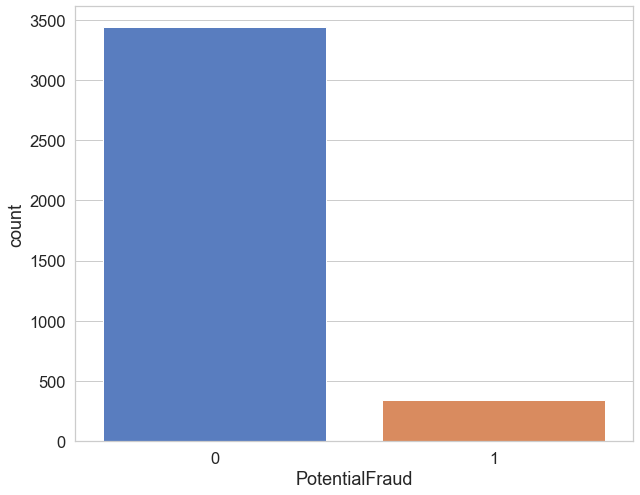

In [142]:
#Here we can see that our target vairable is imbalanced as "0" class is is majority and "1" class is in minority 
plt.figure(figsize=(10,8))
sns.countplot(y_train)

### Sampling Techniques

In [143]:
from collections import Counter
from imblearn.under_sampling import NearMiss

ns=NearMiss(0.8)
x_train_ns,y_train_ns=ns.fit_resample(x_train,y_train) ## Create new train dataset after fitting undersmapling
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({0: 3439, 1: 347})
The number of classes after fit Counter({0: 433, 1: 347})


<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

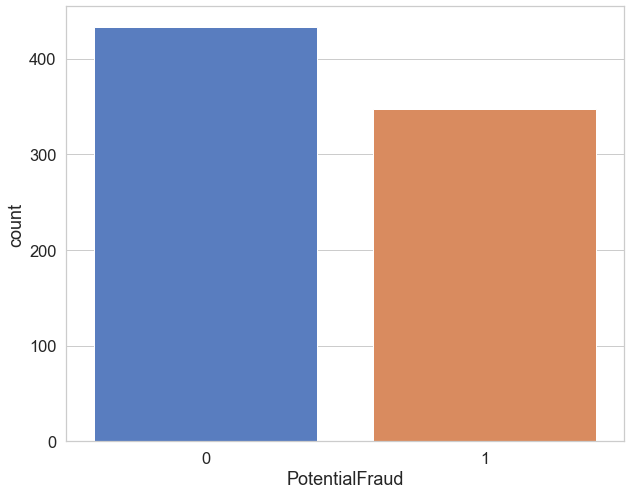

In [144]:
plt.figure(figsize=(10,8))
sns.countplot(y_train_ns)

In [145]:
print("Shape of independent trained dataset after under sampling",x_train_ns.shape)
print("Shape of dependent trained dataset after under sampling", y_train_ns.shape)

Shape of independent trained dataset after under sampling (780, 27)
Shape of dependent trained dataset after under sampling (780,)


In [146]:
from sklearn.ensemble import RandomForestClassifier


clf=RandomForestClassifier()
clf_fit=clf.fit(x_train_ns,y_train_ns)

y_pred_rf=clf_fit.predict(x_test)

In [147]:
print('\033[1m'+"Confusion Matrix \n"+'\033[0m',confusion_matrix(y_test,y_pred_rf))
print('\033[1m'+"\n Accuracy Score \n"+'\033[0m',accuracy_score(y_test,y_pred_rf))
print('\033[1m'+"\n Classification Report \n"+'\033[0m',classification_report(y_test,y_pred_rf))

Confusion Matrix 
 [[743 722]
 [ 21 138]]

 Accuracy Score 
 0.5424876847290641

 Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.51      0.67      1465
           1       0.16      0.87      0.27       159

    accuracy                           0.54      1624
   macro avg       0.57      0.69      0.47      1624
weighted avg       0.89      0.54      0.63      1624



#### Here we can see that this model accuracy is low or not good.This model is able to classify "1" class but not able to classify "0" class

In [148]:
from sklearn.svm import SVC


clf_svc=SVC()
clf_svc_fit=clf_svc.fit(x_train_ns,y_train_ns)

y_pred_svc=clf_svc_fit.predict(x_test)

In [149]:
print('\033[1m'+"Confusion Matrix \n"+'\033[0m',confusion_matrix(y_test,y_pred_svc))
print('\033[1m'+"\n Accuracy Score \n"+'\033[0m',accuracy_score(y_test,y_pred_svc))
print('\033[1m'+"\n Classification Report \n"+'\033[0m',classification_report(y_test,y_pred_svc))

Confusion Matrix 
 [[1142  323]
 [  28  131]]

 Accuracy Score 
 0.7838669950738916

 Classification Report 
               precision    recall  f1-score   support

           0       0.98      0.78      0.87      1465
           1       0.29      0.82      0.43       159

    accuracy                           0.78      1624
   macro avg       0.63      0.80      0.65      1624
weighted avg       0.91      0.78      0.82      1624



#### In SVM also accuracy score is okay, but here are many miscalssification in "0" class, Hence we go for another sampling technique

In [150]:
from imblearn.over_sampling import RandomOverSampler


os=RandomOverSampler(0.75)
x_train_os,y_train_os=os.fit_resample(x_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_os)))

The number of classes before fit Counter({0: 3439, 1: 347})
The number of classes after fit Counter({0: 3439, 1: 2579})


<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

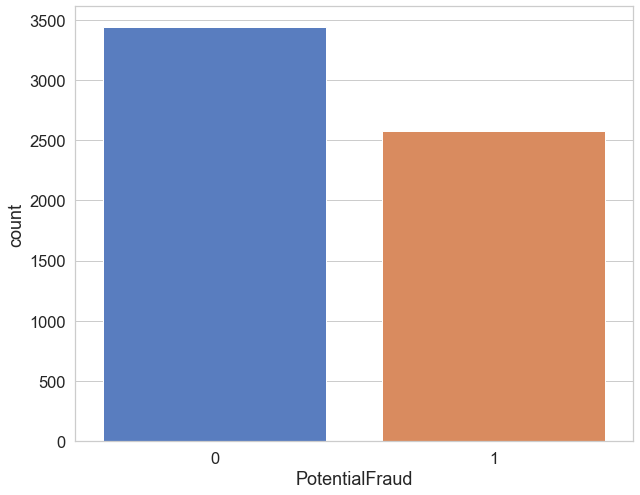

In [151]:
plt.figure(figsize=(10,8))
sns.countplot(y_train_os)

In [152]:
print("Shape of independent trained dataset after Over sampling",x_train_os.shape)
print("Shape of dependent trained dataset after Over sampling", y_train_os.shape)

Shape of independent trained dataset after Over sampling (6018, 27)
Shape of dependent trained dataset after Over sampling (6018,)


In [153]:
from sklearn.ensemble import RandomForestClassifier


os_clf=RandomForestClassifier()
os_clf_fit=os_clf.fit(x_train_os,y_train_os)

y_pred_rf_os=os_clf_fit.predict(x_test)

In [154]:
print('\033[1m'+"Confusion Matrix \n"+'\033[0m',confusion_matrix(y_test,y_pred_rf_os))
print('\033[1m'+"\n Accuracy Score \n"+'\033[0m',accuracy_score(y_test,y_pred_rf_os))
print('\033[1m'+"\n Classification Report \n"+'\033[0m',classification_report(y_test,y_pred_rf_os))

Confusion Matrix 
 [[1423   42]
 [  82   77]]

 Accuracy Score 
 0.9236453201970444

 Classification Report 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1465
           1       0.65      0.48      0.55       159

    accuracy                           0.92      1624
   macro avg       0.80      0.73      0.76      1624
weighted avg       0.92      0.92      0.92      1624



#### Here Random Forest gives us good accuracy score but it is not able to classify majority of "1" class correctly

In [155]:
from sklearn.svm import SVC


clf_svc_os=SVC()
clf_svc_fit_os=clf_svc_os.fit(x_train_os,y_train_os)

y_pred_svc_os=clf_svc_fit_os.predict(x_test)

In [156]:
print('\033[1m'+"Confusion Matrix \n"+'\033[0m',confusion_matrix(y_test,y_pred_svc_os))
print('\033[1m'+"\n Accuracy Score \n"+'\033[0m',accuracy_score(y_test,y_pred_svc_os))
print('\033[1m'+"\n Classification Report \n"+'\033[0m',classification_report(y_test,y_pred_svc_os))

Confusion Matrix 
 [[1359  106]
 [  38  121]]

 Accuracy Score 
 0.9113300492610837

 Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      1465
           1       0.53      0.76      0.63       159

    accuracy                           0.91      1624
   macro avg       0.75      0.84      0.79      1624
weighted avg       0.93      0.91      0.92      1624



#### Here SVM gives us good accuracy score but there are some misclassification in "1" class, Now we want to minimize this misclassification, Hence we go to another sampling technique

In [157]:
from imblearn.combine import SMOTETomek

os=SMOTETomek(0.75)
x_train_st,y_train_st=os.fit_resample(x_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_st)))

The number of classes before fit Counter({0: 3439, 1: 347})
The number of classes after fit Counter({0: 3379, 1: 2519})


<AxesSubplot:xlabel='PotentialFraud', ylabel='count'>

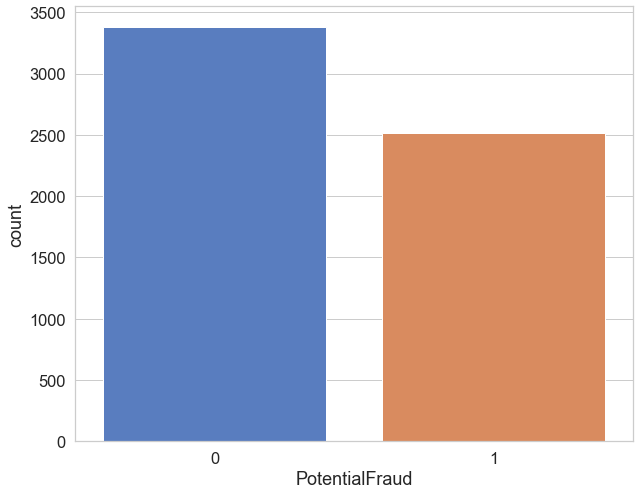

In [158]:
plt.figure(figsize=(10,8))
sns.countplot(y_train_st)

In [159]:
print("Shape of independent trained dataset after SMOTE sampling",x_train_st.shape)
print("Shape of dependent trained dataset after SMOTE sampling", y_train_st.shape)

Shape of independent trained dataset after SMOTE sampling (5898, 27)
Shape of dependent trained dataset after SMOTE sampling (5898,)


In [160]:
from sklearn.tree import DecisionTreeClassifier


clf_dt=DecisionTreeClassifier()
model_dt=clf_dt.fit(x_train_st,y_train_st)
y_pred_dt=model_dt.predict(x_test)

In [161]:
print('\033[1m'+"Confusion Matrix \n"+'\033[0m',confusion_matrix(y_test,y_pred_dt))
print('\033[1m'+"\n Accuracy Score \n"+'\033[0m',accuracy_score(y_test,y_pred_dt))
print('\033[1m'+"\n Classification Report \n"+'\033[0m',classification_report(y_test,y_pred_dt))

Confusion Matrix 
 [[1353  112]
 [  67   92]]

 Accuracy Score 
 0.8897783251231527

 Classification Report 
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      1465
           1       0.45      0.58      0.51       159

    accuracy                           0.89      1624
   macro avg       0.70      0.75      0.72      1624
weighted avg       0.90      0.89      0.90      1624



#### In Decision Tree model accuracy is good but there are many misclassification for both the classes.

In [162]:
from sklearn.naive_bayes import GaussianNB,BernoulliNB


clf_nb=GaussianNB()
model_nb=clf_nb.fit(x_train_st,y_train_st)
y_pred_nb=model_nb.predict(x_test)

In [163]:
print('\033[1m'+"Confusion Matrix \n"+'\033[0m',confusion_matrix(y_test,y_pred_nb))
print('\033[1m'+"\n Accuracy Score \n"+'\033[0m',accuracy_score(y_test,y_pred_nb))
print('\033[1m'+"\n Classification Report \n"+'\033[0m',classification_report(y_test,y_pred_nb))

Confusion Matrix 
 [[1405   60]
 [  79   80]]

 Accuracy Score 
 0.9144088669950738

 Classification Report 
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      1465
           1       0.57      0.50      0.54       159

    accuracy                           0.91      1624
   macro avg       0.76      0.73      0.74      1624
weighted avg       0.91      0.91      0.91      1624



In [164]:
from sklearn.ensemble import GradientBoostingClassifier

clf_GB=GradientBoostingClassifier()
model_GB=clf_GB.fit(x_train_st,y_train_st)
y_pred_GB=model_GB.predict(x_test)

In [165]:
print('\033[1m'+"Confusion Matrix \n"+'\033[0m',confusion_matrix(y_test,y_pred_GB))
print('\033[1m'+"\n Accuracy Score \n"+'\033[0m',accuracy_score(y_test,y_pred_GB))
print('\033[1m'+"\n Classification Report \n"+'\033[0m',classification_report(y_test,y_pred_GB))

Confusion Matrix 
 [[1373   92]
 [  50  109]]

 Accuracy Score 
 0.9125615763546798

 Classification Report 
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1465
           1       0.54      0.69      0.61       159

    accuracy                           0.91      1624
   macro avg       0.75      0.81      0.78      1624
weighted avg       0.92      0.91      0.92      1624



In [166]:
clf_st=RandomForestClassifier()
model_rf=clf_st.fit(x_train_st,y_train_st)
y_pred_rf=model_rf.predict(x_test)

In [167]:
print('\033[1m'+"Confusion Matrix \n"+'\033[0m',confusion_matrix(y_test,y_pred_rf))
print('\033[1m'+"\n Accuracy Score \n"+'\033[0m',accuracy_score(y_test,y_pred_rf))
print('\033[1m'+"\n Classification Report \n"+'\033[0m',classification_report(y_test,y_pred_rf))

Confusion Matrix 
 [[1390   75]
 [  58  101]]

 Accuracy Score 
 0.9181034482758621

 Classification Report 
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      1465
           1       0.57      0.64      0.60       159

    accuracy                           0.92      1624
   macro avg       0.77      0.79      0.78      1624
weighted avg       0.92      0.92      0.92      1624



In [168]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [169]:
probs = model_rf.predict_proba(x_test)
probs = probs[:, 1]
probs

array([0. , 0. , 0. , ..., 0. , 0.2, 0. ])

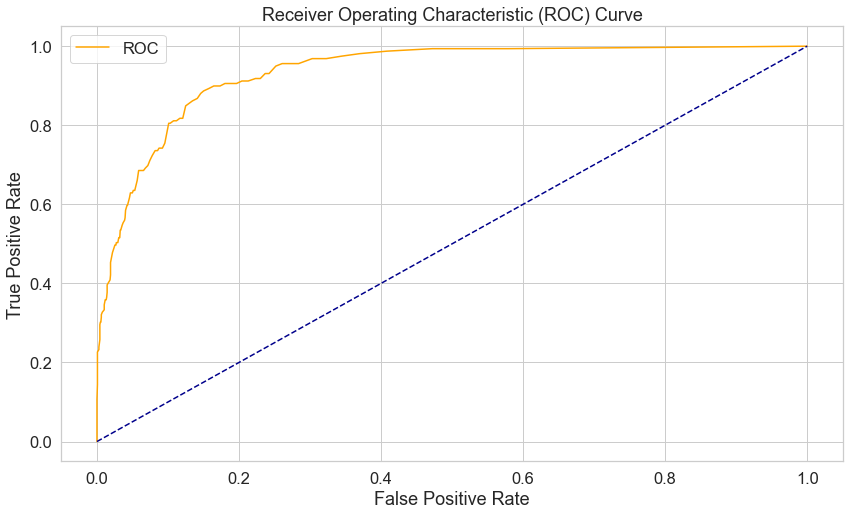

AUC Score 
 0.9344473780239123


In [170]:
fpr1, tpr1, thresholds = roc_curve(y_test, probs)

plot_roc_curve(fpr1, tpr1)


print('\033[1m'+"AUC Score \n"+'\033[0m', roc_auc_score(y_test, probs))

In [171]:
clf_svm=SVC(probability=True)
model_svm=clf_svm.fit(x_train_st,y_train_st)
y_pred_svm=model_svm.predict(x_test)

In [172]:
print('\033[1m'+"Confusion Matrix \n"+'\033[0m',confusion_matrix(y_test,y_pred_svm))
print('\033[1m'+"\n Accuracy Score \n"+'\033[0m',accuracy_score(y_test,y_pred_svm))
print('\033[1m'+"\n Classification Report \n"+'\033[0m',classification_report(y_test,y_pred_svm))

Confusion Matrix 
 [[1352  113]
 [  34  125]]

 Accuracy Score 
 0.9094827586206896

 Classification Report 
               precision    recall  f1-score   support

           0       0.98      0.92      0.95      1465
           1       0.53      0.79      0.63       159

    accuracy                           0.91      1624
   macro avg       0.75      0.85      0.79      1624
weighted avg       0.93      0.91      0.92      1624



#### SVM is working good here as we can see misclassification for classes is also less

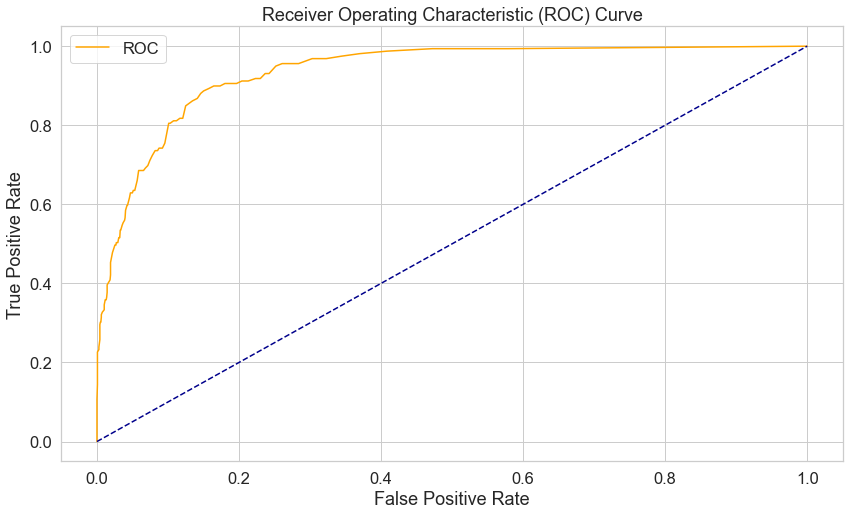

AUC Score 
 0.93


In [173]:
fpr2, tpr2, thresholds = roc_curve(y_test, probs)

plot_roc_curve(fpr2, tpr2)


print('\033[1m'+"AUC Score \n"+'\033[0m', round(roc_auc_score(y_test, probs),2))

In [174]:
rf_accuracy=round(accuracy_score(y_test,y_pred_rf),4)
svm_accuracy=round(accuracy_score(y_test,y_pred_svm),4)
GB_accuracy=round(accuracy_score(y_test,y_pred_GB),4)
DT_accuracy=round(accuracy_score(y_test,y_pred_dt),4)
NB_accuracy=round(accuracy_score(y_test,y_pred_nb),4)

In [175]:
Accuracy=pd.DataFrame({"Model":["Decision Tree","Naive Bayes","Random Forest","SVM","Gradient Boosting"],"Accuracy":[DT_accuracy,NB_accuracy,rf_accuracy,svm_accuracy,GB_accuracy]})
Accuracy

,Model,Accuracy
0,Decision Tree,0.8898
1,Naive Bayes,0.9144
2,Random Forest,0.9181
3,SVM,0.9095
4,Gradient Boosting,0.9126


<AxesSubplot:xlabel='Model', ylabel='Accuracy'>

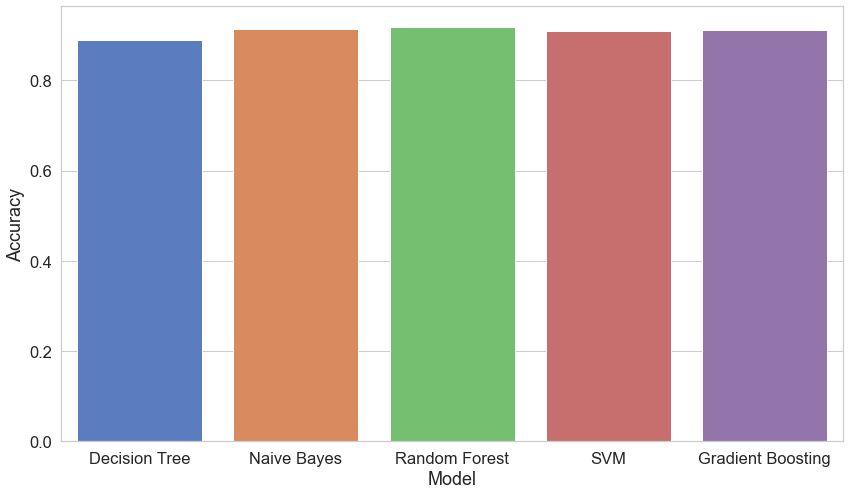

In [176]:
sns.barplot(x=Accuracy.Model,y=Accuracy.Accuracy,)

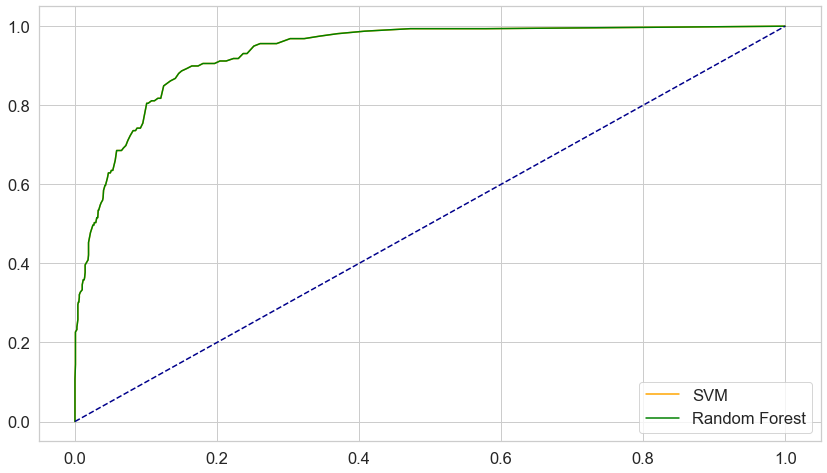

In [177]:
plt.plot(fpr2, tpr2,color='orange',label='SVM')
plt.plot(fpr1, tpr1,color='green',label='Random Forest')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.legend()
plt.show();

#### Hence our final model will be SVM.Prediction of Potential Fraud (Target Variable) on our main Test Data

In [178]:
Test_data.head()

,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmitForDays,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_Cancer,...,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,WhetherDead,N_Types_Physicians,IsDiagnosisCode,N_Procedure,N_UniqueDiagnosis_Claims
0,53790,380.0,32,205,30,77,0.0,79,108,25,...,19,1062090,112392,480740,138980,3.0,312,0,0,584
1,30720,0.0,10,102,24,38,0.0,35,69,15,...,8,384290,48924,244970,61800,0.0,164,0,0,306
2,27230,1238.0,12,38,12,10,8.0,8,17,1,...,3,117160,9612,95200,25210,0.0,60,2,3,127
3,64580,5340.0,5,38,9,10,29.0,21,23,7,...,5,200200,20292,67480,25230,0.0,57,6,3,128
4,61620,670.0,41,190,30,72,0.0,73,109,25,...,13,900400,101460,534460,156960,2.0,292,0,0,541


In [179]:
PotentialFraud=model_svm.predict(Test_data)

Potential_Fraud=pd.DataFrame(PotentialFraud,columns=['PotentialFraud'])

In [180]:
Predicted_Test_data=pd.concat([Test_df,Potential_Fraud],axis=1)

Predicted_Test_data

,Provider,BeneID_count,ClaimID_count,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmitForDays,...,OPAnnualDeductibleAmt,WhetherDead,N_Types_Physicians,IsDiagnosisCode,N_Procedure,N_UniqueDiagnosis_Claims,NoOfMonths_PartACov,NoOfMonths_PartBCov,Age,PotentialFraud
0,PRV51002,169,205,53790,380.0,32,205,30,77,0.0,...,138980,3.0,312,0,0,584,12.0,12.0,80.0,0
1,PRV51006,81,102,30720,0.0,10,102,24,38,0.0,...,61800,0.0,164,0,0,306,12.0,12.0,83.0,0
2,PRV51009,30,39,27230,1238.0,12,38,12,10,8.0,...,25210,0.0,60,2,3,127,12.0,12.0,78.0,0
3,PRV51010,25,38,64580,5340.0,5,38,9,10,29.0,...,25230,0.0,57,6,3,128,12.0,12.0,83.0,0
4,PRV51018,146,190,61620,670.0,41,190,30,72,0.0,...,156960,2.0,292,0,0,541,12.0,12.0,81.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348,PRV57713,10,11,860,0.0,2,11,0,6,0.0,...,5510,0.0,17,0,0,21,12.0,12.0,87.0,0
1349,PRV57726,8,8,1590,0.0,0,8,0,3,0.0,...,9010,0.0,11,0,0,23,12.0,12.0,76.0,0
1350,PRV57745,2,2,510,0.0,1,2,0,2,0.0,...,1420,0.0,4,0,0,4,12.0,12.0,85.0,0
1351,PRV57749,45,49,9980,370.0,9,49,8,21,0.0,...,24780,2.0,78,0,0,114,12.0,12.0,79.0,0


### Feature Importance

In [181]:
# Get numerical feature importances from Random Forest model
importances = list(model_rf.feature_importances_)
print(importances)

feature_list=list(df_clf.columns)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
#print(feature_importances)
# Print out the feature and importances 
print([print('Variable: {:20} Importance: {} '.format(*pair))  for pair in feature_importances])

[0.16901233110206818, 0.15938357416250873, 0.015665009181695305, 0.012005883792113757, 0.023090030069132673, 0.011929651343593447, 0.1126616366592892, 0.013447239075540286, 0.011929773478419853, 0.013123832914978754, 0.025173147756076677, 0.020505208892897052, 0.015409992247592354, 0.010809617420762203, 0.011381221945008806, 0.013191439945751154, 0.014282253581398275, 0.01642966256688116, 0.06568157221806521, 0.047414074124237, 0.021745467308009934, 0.019310826026465267, 0.02452379498525819, 0.014481215012964904, 0.04827326051481985, 0.058583482571551576, 0.030554801102920387]
Variable: InscClaimAmtReimbursed Importance: 0.17 
Variable: DeductibleAmtPaid    Importance: 0.16 
Variable: AdmitForDays         Importance: 0.11 
Variable: IPAnnualReimbursementAmt Importance: 0.07 
Variable: N_Procedure          Importance: 0.06 
Variable: IPAnnualDeductibleAmt Importance: 0.05 
Variable: IsDiagnosisCode      Importance: 0.05 
Variable: ChronicCond_KidneyDisease Importance: 0.03 
Variable: N_

In [182]:
# Get numerical feature importances from Gradient Boosting model
importances = list(model_GB.feature_importances_)
print(importances)

[0.7727349092382487, 0.029618708723408674, 0.001977678649710621, 0.00026309852194544126, 0.00913225576270944, 0.0030108475335618445, 0.029245661909526148, 0.0009266410709479953, 0.00013189641608184376, 0.002256248973376866, 3.4795988362522747e-05, 0.006128412652573704, 0.0015734093194245664, 0.0014272852781391306, 0.00178323818488529, 0.0005391934987350561, 0.0030884534064826398, 0.004853304632785524, 0.004425587075549554, 0.006561989401689906, 0.017520706389243187, 0.011475819582346239, 0.061901160707627155, 0.0012208975860271874, 0.020034135610174177, 0.006599833386264846, 0.0015338305001715978]


In [183]:
feature_list=list(df_clf.columns)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
#print(feature_importances)
# Print out the feature and importances 
print([print('Variable: {:20} Importance: {} '.format(*pair))  for pair in feature_importances])

Variable: InscClaimAmtReimbursed Importance: 0.77 
Variable: WhetherDead          Importance: 0.06 
Variable: DeductibleAmtPaid    Importance: 0.03 
Variable: AdmitForDays         Importance: 0.03 
Variable: OPAnnualReimbursementAmt Importance: 0.02 
Variable: IsDiagnosisCode      Importance: 0.02 
Variable: OperatingPhysician   Importance: 0.01 
Variable: ChronicCond_ObstrPulmonary Importance: 0.01 
Variable: IPAnnualDeductibleAmt Importance: 0.01 
Variable: OPAnnualDeductibleAmt Importance: 0.01 
Variable: N_Procedure          Importance: 0.01 
Variable: RenalDiseaseIndicator Importance: 0.0 
Variable: AttendingPhysician   Importance: 0.0 
Variable: OtherPhysician       Importance: 0.0 
Variable: ChronicCond_Alzheimer Importance: 0.0 
Variable: ChronicCond_Heartfailure Importance: 0.0 
Variable: ChronicCond_Cancer   Importance: 0.0 
Variable: ChronicCond_KidneyDisease Importance: 0.0 
Variable: ChronicCond_Depression Importance: 0.0 
Variable: ChronicCond_Diabetes Importance: 0.0 
Va

In [184]:
from xgboost import XGBClassifier 


xg_model=XGBClassifier()
sg_model_fit=xg_model.fit(x_train_st,y_train_st)

[00:43:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

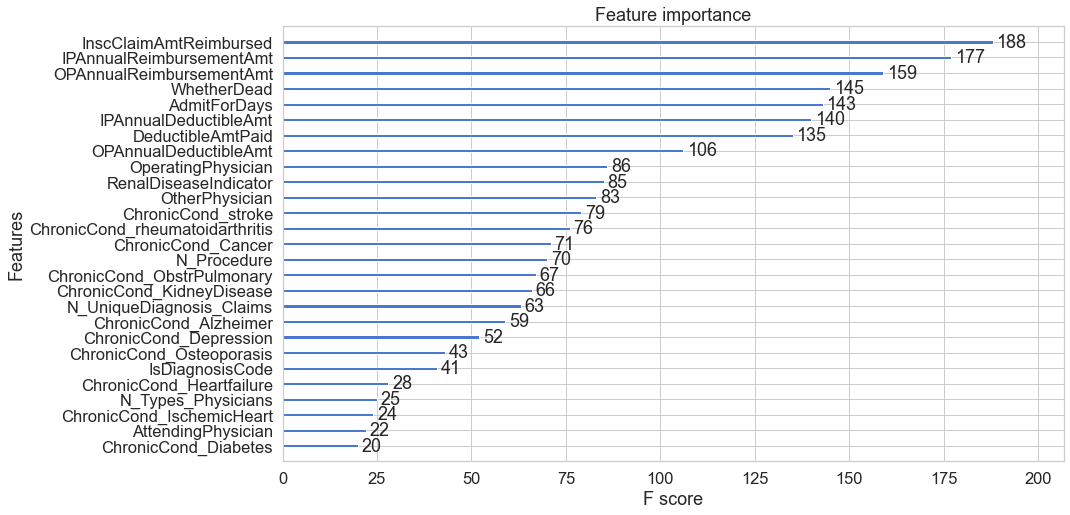

In [185]:
from xgboost import plot_importance
plot_importance(sg_model_fit)

In [186]:
#### Hence from above we can conclude that important features are :

x_train_imp=x_train_st[['InscClaimAmtReimbursed','AdmitForDays','DeductibleAmtPaid','N_Procedure','IsDiagnosisCode']]
x_test_imp=x_test[['InscClaimAmtReimbursed','AdmitForDays','DeductibleAmtPaid','N_Procedure','IsDiagnosisCode']]
x_train_imp.head()

,InscClaimAmtReimbursed,AdmitForDays,DeductibleAmtPaid,N_Procedure,IsDiagnosisCode
0,21720,0.0,80.0,0,0
1,105130,0.0,1390.0,1,0
2,50070,0.0,170.0,0,0
3,5030,0.0,0.0,0,0
4,6000,3.0,1068.0,1,1


#### Now we will do the modelling with important features only

In [187]:
## SVM model

svm_imp=SVC(probability=True)
svm_imp=svm_imp.fit(x_train_imp,y_train_st)
y_pred_svm2=svm_imp.predict(x_test_imp)

In [188]:
print('\033[1m'+"Confusion Matrix \n"+'\033[0m',confusion_matrix(y_test,y_pred_svm2))
print('\033[1m'+"\n Accuracy Score \n"+'\033[0m',accuracy_score(y_test,y_pred_svm2))
print('\033[1m'+"\n Classification Report \n"+'\033[0m',classification_report(y_test,y_pred_svm2))

Confusion Matrix 
 [[1325  140]
 [  28  131]]

 Accuracy Score 
 0.896551724137931

 Classification Report 
               precision    recall  f1-score   support

           0       0.98      0.90      0.94      1465
           1       0.48      0.82      0.61       159

    accuracy                           0.90      1624
   macro avg       0.73      0.86      0.77      1624
weighted avg       0.93      0.90      0.91      1624



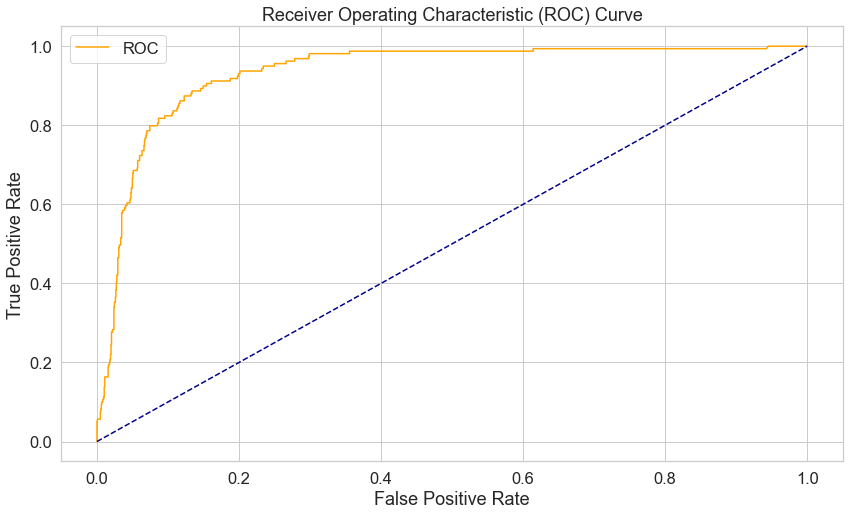

AUC Score 
 0.93


In [189]:
probs_new = svm_imp.predict_proba(x_test_imp)
probs_new = probs_new[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, probs_new)

plot_roc_curve(fpr, tpr)


print('\033[1m'+"AUC Score \n"+'\033[0m', round(roc_auc_score(y_test, probs_new),2))